Diego García Maroto (diegar20@ucm.es)

# Práctica 2: Análisis de extremos, análisis espectral y filtros

In [1]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import pandas as pd

# Estadística
from scipy import stats 
from scipy import special
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

Vamos a calcular los siguientes indices de extremos:

![title](./img/index.png)

Lectura de datos (necesitaremos tanto Tmax como Tmin):

In [2]:
path = './data/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
display(data_max)
data_min

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tx       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily maximum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, maximum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tn       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily minimum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, minimum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

In [3]:
# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat
tmin = data_min.tn
tmax = data_max.tx
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

---

Calculamos las cold_nights:

In [4]:
# Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per)
    percent_cold_nights = num_cold/365*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tx10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days


lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tminO = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmin_p10_O = xr.open_dataarray('./outs/tmin_p10_O.nc')
    percent_cold_nights_O = xr.open_dataarray('./outs/percent_cold_nights_O.nc')
except: 
    tmin_p10_O, percent_cold_nights_O = cold_nights_xclim(tminO,['1901','2014'])
    tmin_p10_O.to_netcdf('./outs/tmin_p10_O.nc')
    percent_cold_nights_O.to_netcdf('./outs/percent_cold_nights_O.nc')
display(tmin_p10_O)
display(percent_cold_nights_O)

In [5]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tminO = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmin_p10_O = xr.open_dataarray('./outs/tmin_p10_O.nc')
    percent_cold_nights_O = xr.open_dataarray('./outs/percent_cold_nights_O.nc')
except: 
    tmin_p10_O, percent_cold_nights_O = cold_nights_xclim(tminO,['1901','2014'])
    tmin_p10_O.to_netcdf('./outs/tmin_p10_O.nc')
    percent_cold_nights_O.to_netcdf('./outs/percent_cold_nights_O.nc')
display(tmin_p10_O)
display(percent_cold_nights_O)

<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-20 01:36:07] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

In [6]:
try: 
    tmin_p10_E = xr.open_dataarray('./outs/tmin_p10_E.nc')
    percent_cold_nights_E = xr.open_dataarray('./outs/percent_cold_nights_E.nc')
    print('Leido de outs')
except:
    tmin_p10_E, percent_cold_nights_E = cold_nights_xclim(tmin.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmin_p10_E.to_netcdf('./outs/tmin_p10_E.nc')
    percent_cold_nights_E.to_netcdf('./outs/percent_cold_nights_E.nc')

Leido de outs


In [7]:
try: 
    tmin_p10_C = xr.open_dataarray('./outs/tmin_p10_C.nc')
    percent_cold_nights_C = xr.open_dataarray('./outs/percent_cold_nights_C.nc')
    print('Leido de outs')
except:
    tmin_p10_C, percent_cold_nights_C = cold_nights_xclim(tmin.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmin_p10_C.to_netcdf('./outs/tmin_p10_C.nc')
    percent_cold_nights_C.to_netcdf('./outs/percent_cold_nights_C.nc')

Leido de outs


In [8]:
try: 
    tmin_p10_S = xr.open_dataarray('./outs/tmin_p10_S.nc')
    percent_cold_nights_S = xr.open_dataarray('./outs/percent_cold_nights_S.nc')
    print('Leido de outs')
except:
    tmin_p10_S, percent_cold_nights_S = cold_nights_xclim(tmin.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmin_p10_S.to_netcdf('./outs/tmin_p10_S.nc')
    percent_cold_nights_S.to_netcdf('./outs/percent_cold_nights_S.nc')


Leido de outs


In [9]:
try: 
    tmin_p10_N = xr.open_dataarray('./outs/tmin_p10_N.nc')
    percent_cold_nights_N = xr.open_dataarray('./outs/percent_cold_nights_N.nc')
    print('Leido de outs')
except:
    tmin_p10_N, percent_cold_nights_N = cold_nights_xclim(tmin.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmin_p10_N.to_netcdf('./outs/tmin_p10_N.nc')
    percent_cold_nights_N.to_netcdf('./outs/percent_cold_nights_N.nc')


Leido de outs


<xarray.DataArray ()>
array(16.34943523)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(20.84114396)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(19.47849075)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(21.20644076)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(15.23912521)
Coordinates:
    percentiles  int32 ...


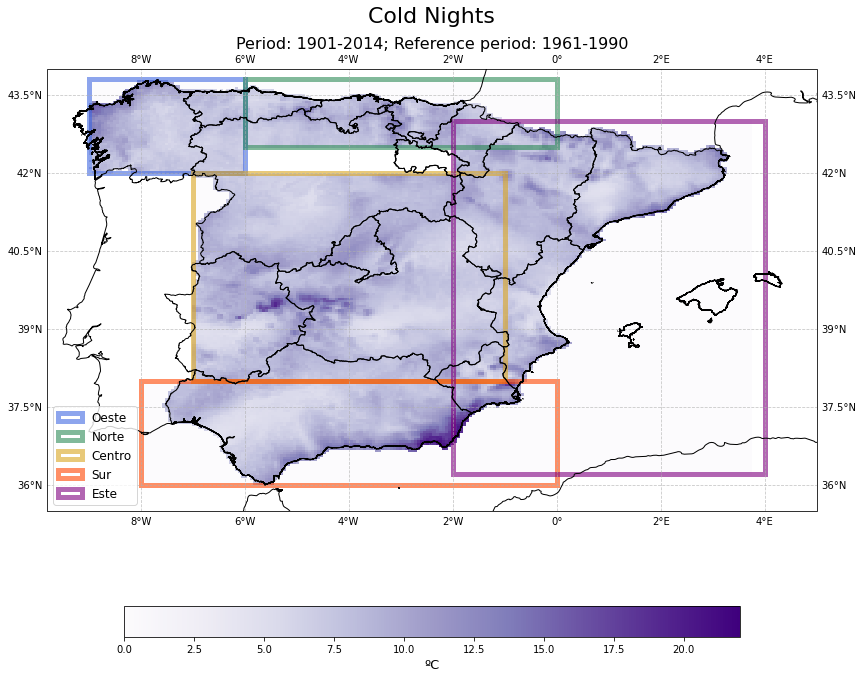

In [10]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'

var = percent_cold_nights_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = percent_cold_nights_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = percent_cold_nights_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var = percent_cold_nights_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var = percent_cold_nights_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='ºC',size=13)
cbar.ax.set_xlim(0, 22)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

In [11]:
#fig.savefig('cold_nights.png',dpi=600,facecolor='w')

In [12]:
percent_cold_nights_N

<xarray.DataArray (time: 114, lat: 29, lon: 103)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 1.917808,  1.643836, ..., 11.232877, 11.780822],
        [ 1.917808,  2.191781, ..., 10.136986, 10.958904]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 3.013699,  2.191781, ...,  6.30137 ,  7.39726 ],
        [ 3.561644,  3.561644, ...,  6.849315,  6.575342]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [12.328767, 13.424658, ...,  9.863014,  9.315068],
        [14.246575, 15.068493, ...,  8.493151,  7.671233]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 8.493151,  7.945205, ...,  4.657534,  4.109589],
        [ 7.945205,  7.671233, ...,  4.383562,  4.109589]]])
Coordinates:
  * lon          (lon) float64 -5.987 -5.929 -5.87 ... -0.1371 -0.07858 -0.02008
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.59 42.55 42.5
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Mapa de diferencias:

<xarray.DataArray ()>
array(33.42592593)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(35.77694236)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(58.63412981)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(12.36712471)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(35.62200074)
Coordinates:
    percentiles  int32 10


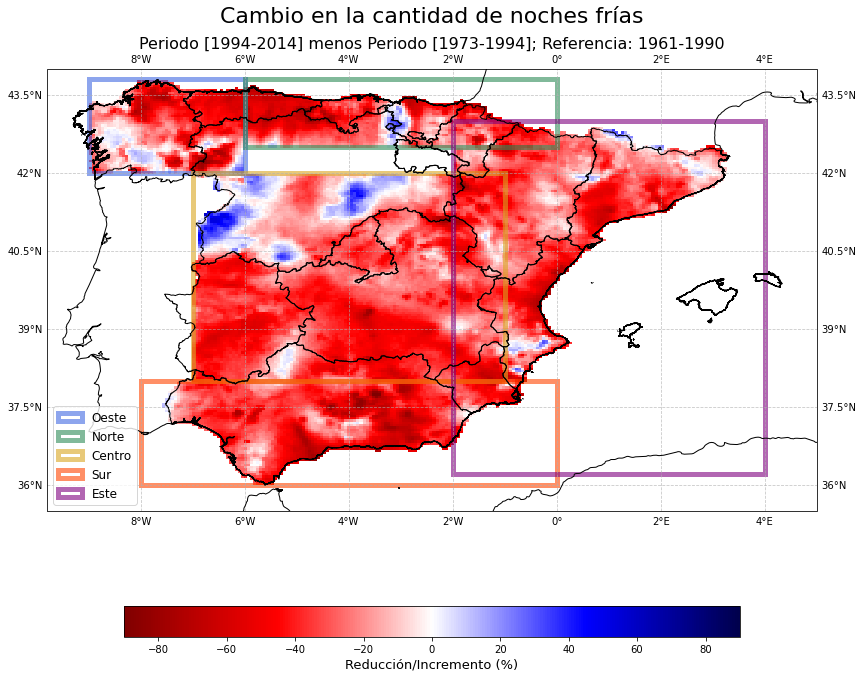

In [13]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de noches frías',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90

var = (percent_cold_nights_O.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_O.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_O.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = (percent_cold_nights_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = (percent_cold_nights_C.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_C.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_C.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var = (percent_cold_nights_S.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_S.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_S.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var = (percent_cold_nights_N.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_nights_N.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_nights_N.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

In [14]:
#fig.savefig('cambios_nights.png',dpi=600,facecolor='w')

Ahora las series temporales:

In [15]:
from matplotlib import style

def series_style():
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

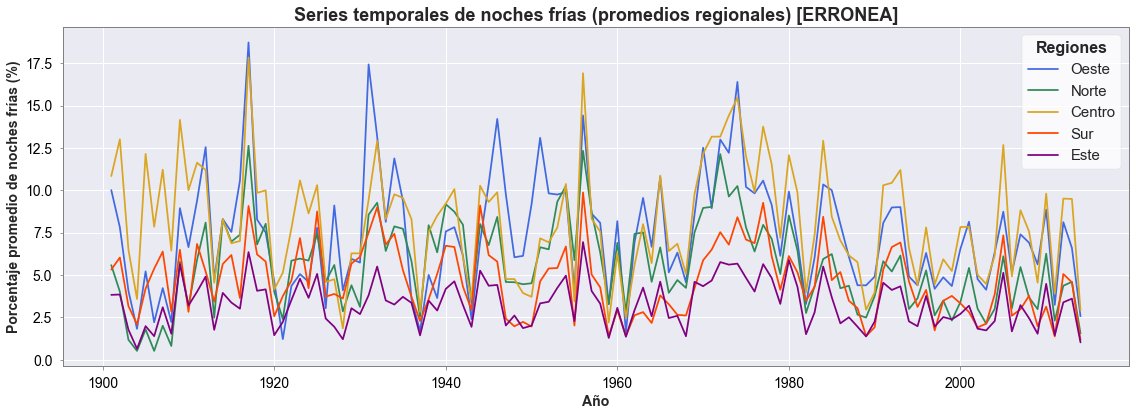

In [16]:
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,percent_cold_nights_O.mean(dim=['lon','lat']),color='royalblue',label='Oeste')
ax.plot(años,percent_cold_nights_N.mean(dim=['lon','lat']),color='seagreen',label='Norte')
ax.plot(años,percent_cold_nights_C.mean(dim=['lon','lat']),color='goldenrod',label='Centro')
ax.plot(años,percent_cold_nights_S.mean(dim=['lon','lat']),color='orangered',label='Sur')
ax.plot(años,percent_cold_nights_E.mean(dim=['lon','lat']),color='purple',label='Este')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales) [ERRONEA]')
plt.tight_layout()

In [17]:
display(tmin_p10_E.sel(lon='4',lat='39', method="nearest"))
display(percent_cold_nights_O)

<xarray.DataArray 'per' (dayofyear: 366)>
[366 values with dtype=float64]
Coordinates:
    lon          float64 3.724
    lat          float64 38.99
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:34:29] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      , 10.684932, ...,  5.753425,  5.479452],
        [ 0.      ,  9.589041, ...,  6.027397,  6.849315]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  8.493151, ...,  7.123288,  6.027397],
        [ 0.      ,  8.219178, ...,  8.219178,  7.123288]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  5.479452, ..., 13.150685, 14.794521],
        [ 0.      ,  5.479452, ..., 13.972603, 14.794521]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  1.09589 , ...,  6.849315,  6.575342],
        [ 0.      ,  0.547945, ...,  6.575342,  6.849315]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Hay que corregirlas, volver a poner los nan en las zonas de océano (si no se infravalora el porcentaje):

In [18]:
def correct_series(percent,tmin=tmin,freq='YS'):
    '''El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media'''
    tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])

        result = corr_R_x.mean(dim=['lon','lat'])

    return result

In [19]:
corr_E = correct_series(percent_cold_nights_E)

In [20]:
corr_N = correct_series(percent_cold_nights_N)

In [21]:
corr_S = correct_series(percent_cold_nights_S)

In [22]:
corr_O = correct_series(percent_cold_nights_O)

In [23]:
corr_C = correct_series(percent_cold_nights_C)

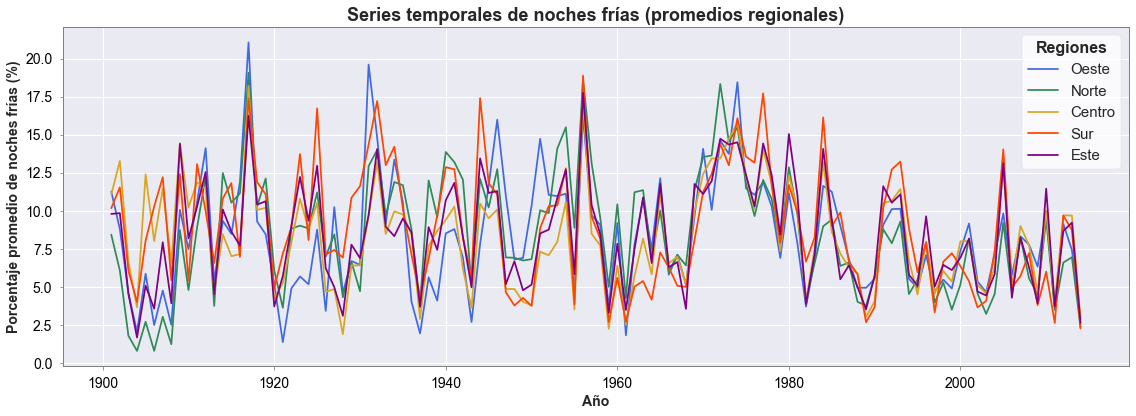

In [24]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,corr_N,color='seagreen',label='Norte')
ax.plot(años,corr_C,color='goldenrod',label='Centro')
ax.plot(años,corr_S,color='orangered',label='Sur')
ax.plot(años,corr_E,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

In [25]:
#fig.savefig('series_reg.png',dpi=600,facecolor='w')

In [26]:
tminOm = tminO.mean(dim=['lon','lat'],keep_attrs=True)
tminOm



<xarray.DataArray 'tn' (Time: 41638)>
array([ 2.3032253 ,  1.679131  ,  1.7624679 , ..., -1.5089166 ,
       -1.5696096 , -0.08151622], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

In [27]:
tminOm = tminOm.rename({'Time': 'time'})
tminOm.attrs['units'] = 'degC'

In [28]:
basem = tminOm.sel(time=slice('1961','1990'))
basem

<xarray.DataArray 'tn' (time: 10957)>
array([2.3487177 , 0.86258835, 2.015206  , ..., 3.645706  , 5.783328  ,
       5.418103  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 1990-12-31
Attributes:
    units:      degC
    long_name:  Minimum temperature

In [29]:
tas_perm = percentile_doy(basem, per=10).sel(percentiles=10)
cold_daysm = tn10p(tminOm.sel(time=slice('1901','2014')), tas_perm)

In [30]:
perm = cold_daysm/365*100

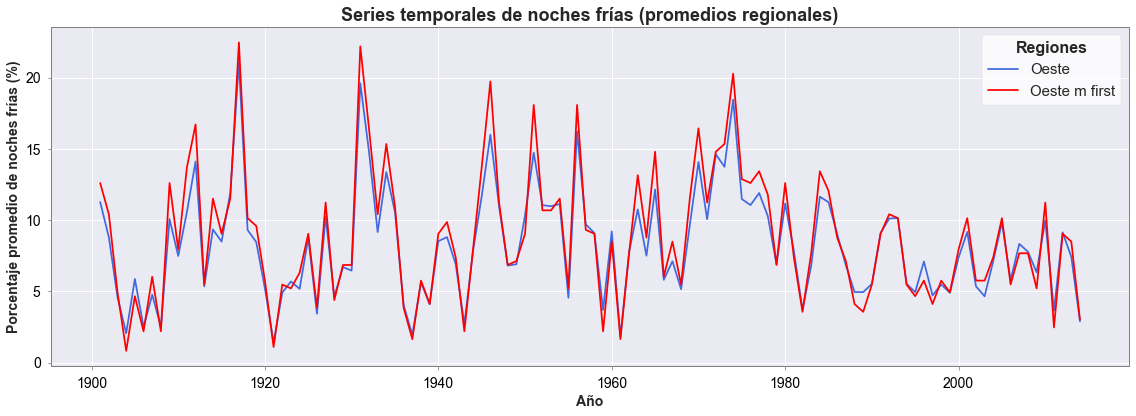

In [31]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,perm,color='r',label='Oeste m first')


ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

---

Vamos con los cold_days:

In [32]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tmaxO = tmax.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmax_p10_O = xr.open_dataarray('./outs/tmax_p10_O_si.nc')
    percent_cold_days_O = xr.open_dataarray('./outs/percent_cold_days_O_si.nc')
except: 
    tmax_p10_O, percent_cold_days_O = cold_nights_xclim(tmaxO,['1901','2014'])
    tmax_p10_O.to_netcdf('./outs/tmax_p10_O_si.nc')
    percent_cold_days_O.to_netcdf('./outs/percent_cold_days_O_si.nc')
display(tmax_p10_O)
display(percent_cold_days_O)

<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Maximum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-20 01:52:15] per: percentile_doy(arr=tx, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

In [ ]:
def cold_nights_xclim_m(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per,freq='MS')
    percent_cold_nights = num_cold/num_cold.time.dt.days_in_month*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

tmax_p10_O_m, percent_cold_days_O_m = cold_nights_xclim_m(tminO,['1973','2014'])
tmax_p10_O_m.to_netcdf('./outs/tmax_p10_O_m.nc')
percent_cold_days_O_m.to_netcdf('./outs/percent_cold_days_O_m.nc')
display(tmax_p10_O_m)
display(percent_cold_days_O_m)

In [33]:
try: 
    tmax_p10_E = xr.open_dataarray('./outs/tmax_p10_E.nc')
    percent_cold_days_E = xr.open_dataarray('./outs/percent_cold_days_E.nc')
    print('Leido de outs')
except:
    tmax_p10_E, percent_cold_days_E = cold_nights_xclim(tmax.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmax_p10_E.to_netcdf('./outs/tmax_p10_E.nc')
    percent_cold_days_E.to_netcdf('./outs/percent_cold_days_E.nc')

Leido de outs


In [34]:
try: 
    tmax_p10_C = xr.open_dataarray('./outs/tmax_p10_C.nc')
    percent_cold_days_C = xr.open_dataarray('./outs/percent_cold_days_C.nc')
    print('Leido de outs')
except:
    tmax_p10_C, percent_cold_days_C = cold_nights_xclim(tmax.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmax_p10_C.to_netcdf('./outs/tmax_p10_C.nc')
    percent_cold_days_C.to_netcdf('./outs/percent_cold_days_C.nc')

Leido de outs


In [35]:
try: 
    tmax_p10_S = xr.open_dataarray('./outs/tmax_p10_S.nc')
    percent_cold_days_S = xr.open_dataarray('./outs/percent_cold_days_S.nc')
    print('Leido de outs')
except:
    tmax_p10_S, percent_cold_days_S = cold_nights_xclim(tmax.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmax_p10_S.to_netcdf('./outs/tmax_p10_S.nc')
    percent_cold_days_S.to_netcdf('./outs/percent_cold_days_S.nc')

Leido de outs


In [36]:
try: 
    tmax_p10_N = xr.open_dataarray('./outs/tmax_p10_N.nc')
    percent_cold_days_N = xr.open_dataarray('./outs/percent_cold_days_N.nc')
    print('Leido de outs')
except:
    tmax_p10_N, percent_cold_days_N = cold_nights_xclim(tmax.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmax_p10_N.to_netcdf('./outs/tmax_p10_N.nc')
    percent_cold_days_N.to_netcdf('./outs/percent_cold_days_N.nc')


Leido de outs


<xarray.DataArray ()>
array(14.8209565)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(15.71497236)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(18.02451334)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(14.48209565)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(14.94592646)
Coordinates:
    percentiles  int32 ...


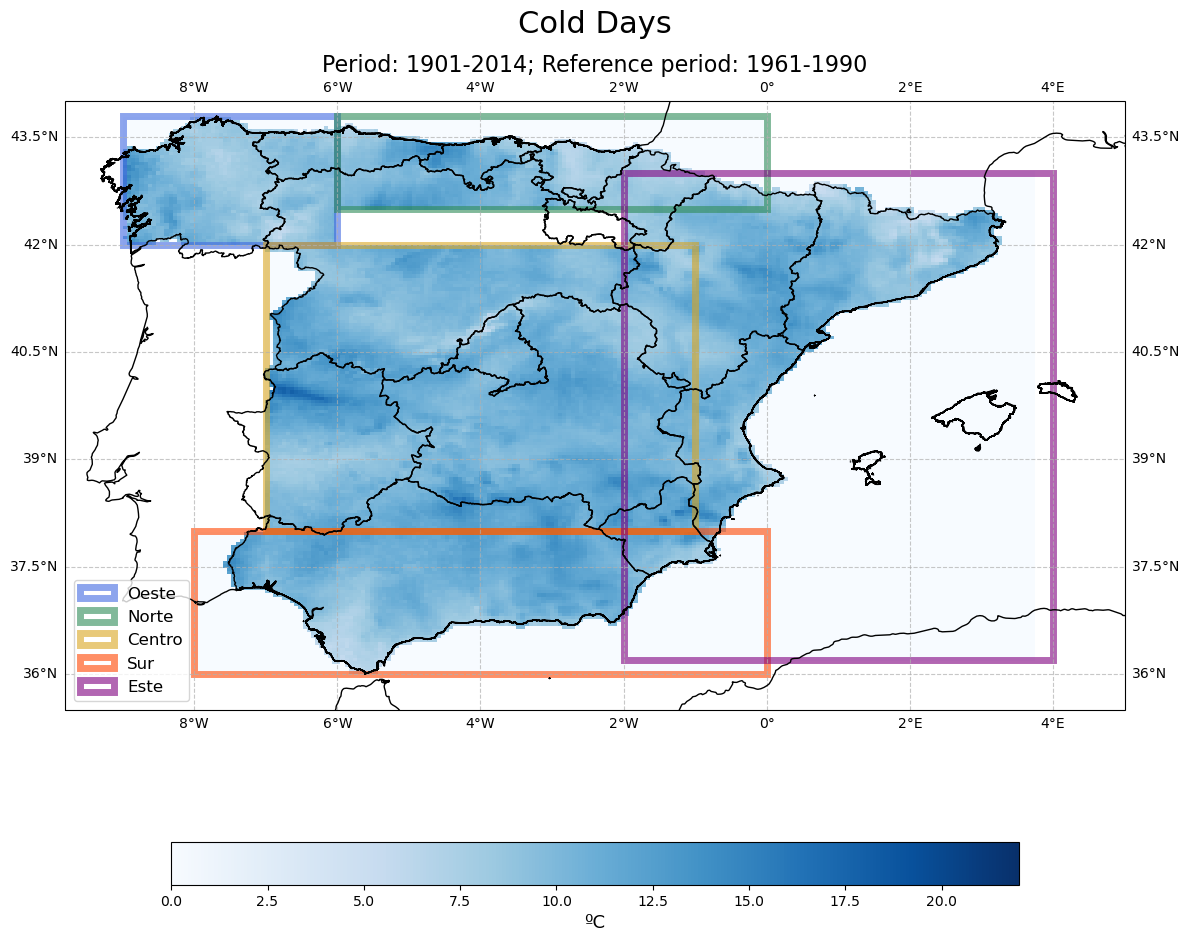

In [37]:
plt.style.use('default')
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Days',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Blues'

var =  percent_cold_days_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var =  percent_cold_days_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var =  percent_cold_days_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var =  percent_cold_days_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var =  percent_cold_days_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='ºC',size=13)
cbar.ax.set_xlim(0, 22)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

<xarray.DataArray ()>
array(51.70375148)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(75.29467232)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(75.47211731)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(86.91623085)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(49.36242279)
Coordinates:
    percentiles  int32 10


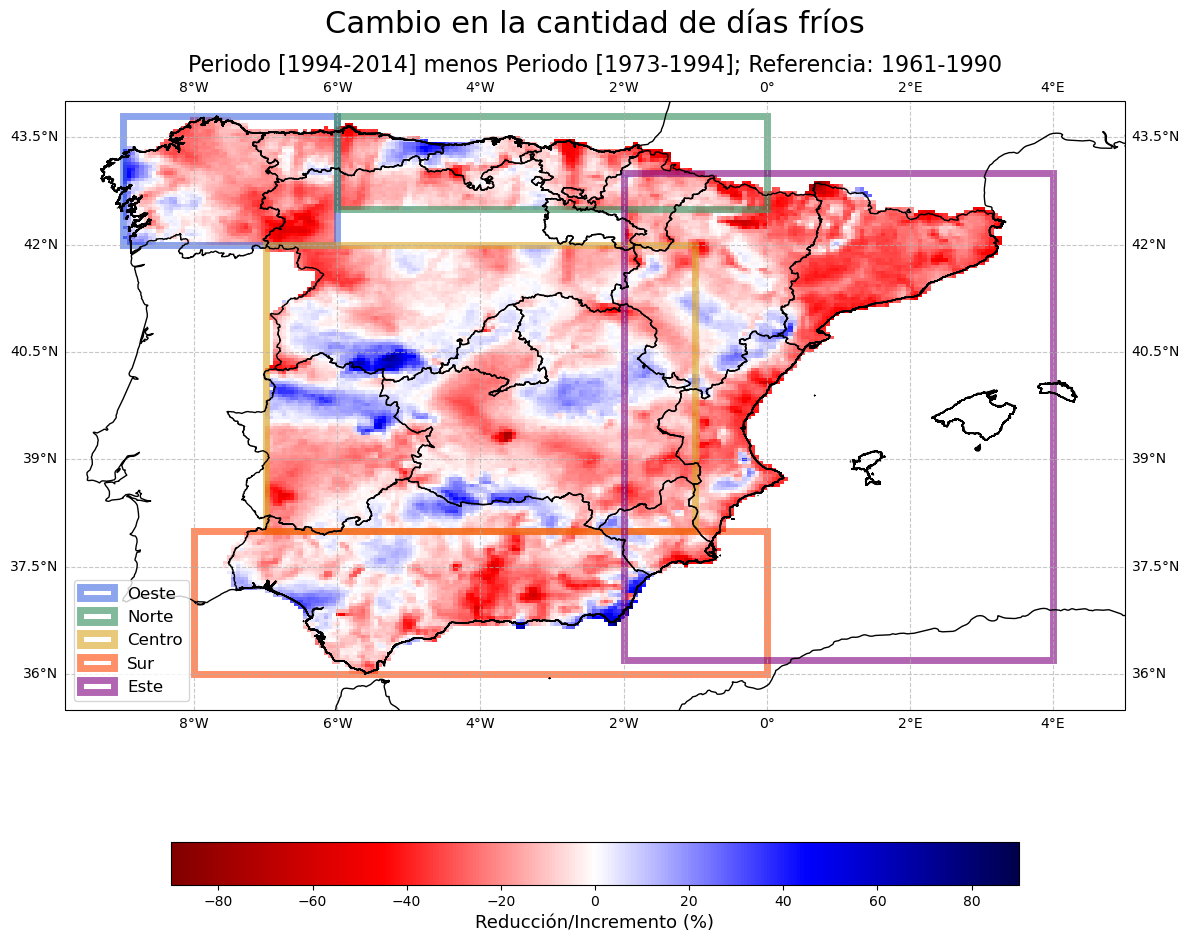

In [38]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cambio en la cantidad de días fríos',size=22)
plt.title('Periodo [1994-2014] menos Periodo [1973-1994]; Referencia: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = cm.get_cmap('seismic_r')
vmin = -90
vmax = 90

var = (percent_cold_days_O.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_O.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_O.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = (percent_cold_days_E.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_E.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = (percent_cold_days_C.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_C.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_C.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var = (percent_cold_days_S.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_S.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_S.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var = (percent_cold_days_N.sel(time=slice('1994','2015')).mean(dim='time')-percent_cold_days_N.sel(time=slice('1973','1994')).mean(dim='time'))/percent_cold_days_N.sel(time=slice('1973','1994')).mean(dim='time')*100
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=vmin, vmax=vmax, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label=u'Reducción/Incremento (%)',size=13)
cbar.ax.set_xlim(vmin, vmax)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

In [39]:
#fig.savefig('cambios_days.png',dpi=600,facecolor='w')

In [40]:
corr_E_d = correct_series(percent_cold_days_E)

In [41]:
corr_N_d = correct_series(percent_cold_days_N)

In [42]:
corr_S_d = correct_series(percent_cold_days_S)

In [43]:
corr_O_d = correct_series(percent_cold_days_O)

In [44]:
corr_C_d = correct_series(percent_cold_days_C)

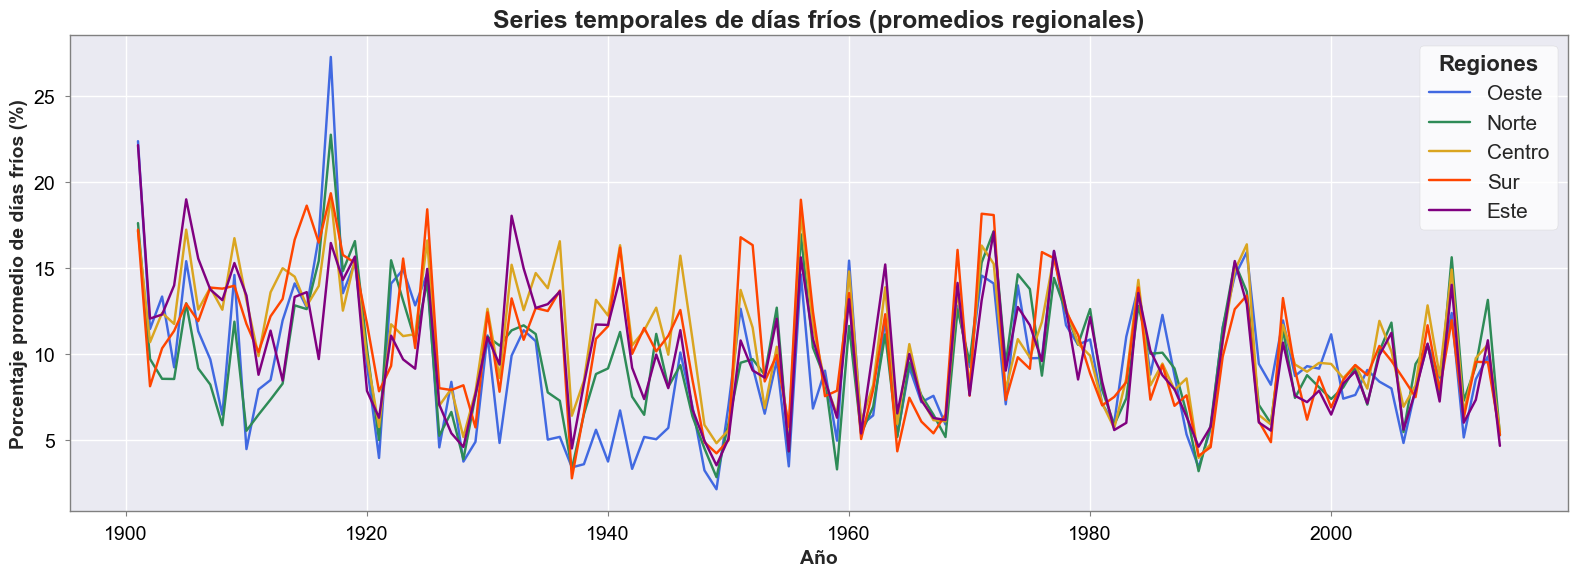

In [45]:
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O_d,color='royalblue',label='Oeste')
ax.plot(años,corr_N_d,color='seagreen',label='Norte')
ax.plot(años,corr_C_d,color='goldenrod',label='Centro')
ax.plot(años,corr_S_d,color='orangered',label='Sur')
ax.plot(años,corr_E_d,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')
plt.tight_layout()

---

Voy a intentar hacerlo mensual:

In [82]:
tmax_O = tmax.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
tmax2_O = tmax_O.rename({'Time': 'time'})
tmax2_O.attrs['units'] = 'degC'
try: 
    num_cold_days_O_m = xr.open_dataarray('./outs/tmax_p10_O_m_full.nc')
except: 
    num_cold_days_O_m = tx10p(tmax2_O.sel(time=slice('1901','2014')),tmax_p10_O,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_days_O_m.to_netcdf('./outs/tmax_p10_O_m_full.nc')

In [83]:
tmin_O = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
tmin_O = tmin_O.rename({'Time': 'time'})
tmin_O.attrs['units'] = 'degC'
try: 
    num_cold_nights_O_m = xr.open_dataarray('./outs/percent_cold_nights_O_m_FULL.nc')
except: 
    num_cold_nights_O_m = tx10p(tmin_O.sel(time=slice('1901','2014')),tmin_p10_O,freq='MS') #.mean(dim=['lon','lat'])
    num_cold_nights_O_m.to_netcdf('./outs/percent_cold_nights_O_m_FULL.nc')

In [84]:
percent_cold_nights_O_m = num_cold_nights_O_m/num_cold_nights_O_m.time.dt.days_in_month*100
percent_cold_days_O_m = num_cold_days_O_m/num_cold_days_O_m.time.dt.days_in_month*100


In [85]:
percent_cold_days_O_m

<xarray.DataArray (time: 1368, lat: 40, lon: 51)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  9.67741935,   9.67741935,  12.90322581, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,  12.90322581,  19.35483871, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,   9.67741935,  19.35483871, ...,   6.4516129 ,
           6.4516129 ,   3.22580645]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   3.33333333,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   3.33333333, ...,   6.66666667,
           3.33333333,   3.33333333]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  3.22580645,   3.22580645,   3.22580645, ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   3.22580645],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * time         (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

tmax_p10_O_m, percent_cold_days_O_m = cold_nights_xclim_m(tmax_O,['1973','2014'])
#tmax_p10_O_m.to_netcdf('./outs/tmax_p10_O_m.nc')
#percent_cold_days_O_m.to_netcdf('./outs/percent_cold_days_O_m.nc')
display(tmax_p10_O_m)
display(percent_cold_days_O_m)

In [86]:
percent_cold_days_O_m

<xarray.DataArray (time: 1368, lat: 40, lon: 51)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  9.67741935,   9.67741935,  12.90322581, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,  12.90322581,  19.35483871, ...,   3.22580645,
           3.22580645,   3.22580645],
        [  0.        ,   9.67741935,  19.35483871, ...,   6.4516129 ,
           6.4516129 ,   3.22580645]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [  0.        ,   3.33333333,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   0.        , ...,   6.66666667,
           6.66666667,   3.33333333],
        [  0.        ,   0.        ,   3.33333333, ...,   6.66666667,
           3.33333333,   3.33333333]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  3.22580645,   3.22580645,   3.22580645, ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   3.22580645],
        [  0.        ,   3.22580645,   9.67741935, ...,   0.        ,
           0.        ,   0.        ]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * time         (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

In [87]:
# Se pone en porcentaje dividiendo por el número de meses
#percent_cold_days_O_monthly/percent_cold_days_O_monthly.time.dt.days_in_month*100

In [88]:
corr_O_monthly = correct_series(percent_cold_days_O_m,freq='MS')

In [89]:
corr_O_monthly

<xarray.DataArray (time: 1368)>
array([11.16762101, 84.18845487, 33.4850802 , ...,  0.7486574 ,
        4.88055862,  6.58320589])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01

In [90]:
corrN_O_monthly = correct_series(percent_cold_nights_O_m,freq='MS')

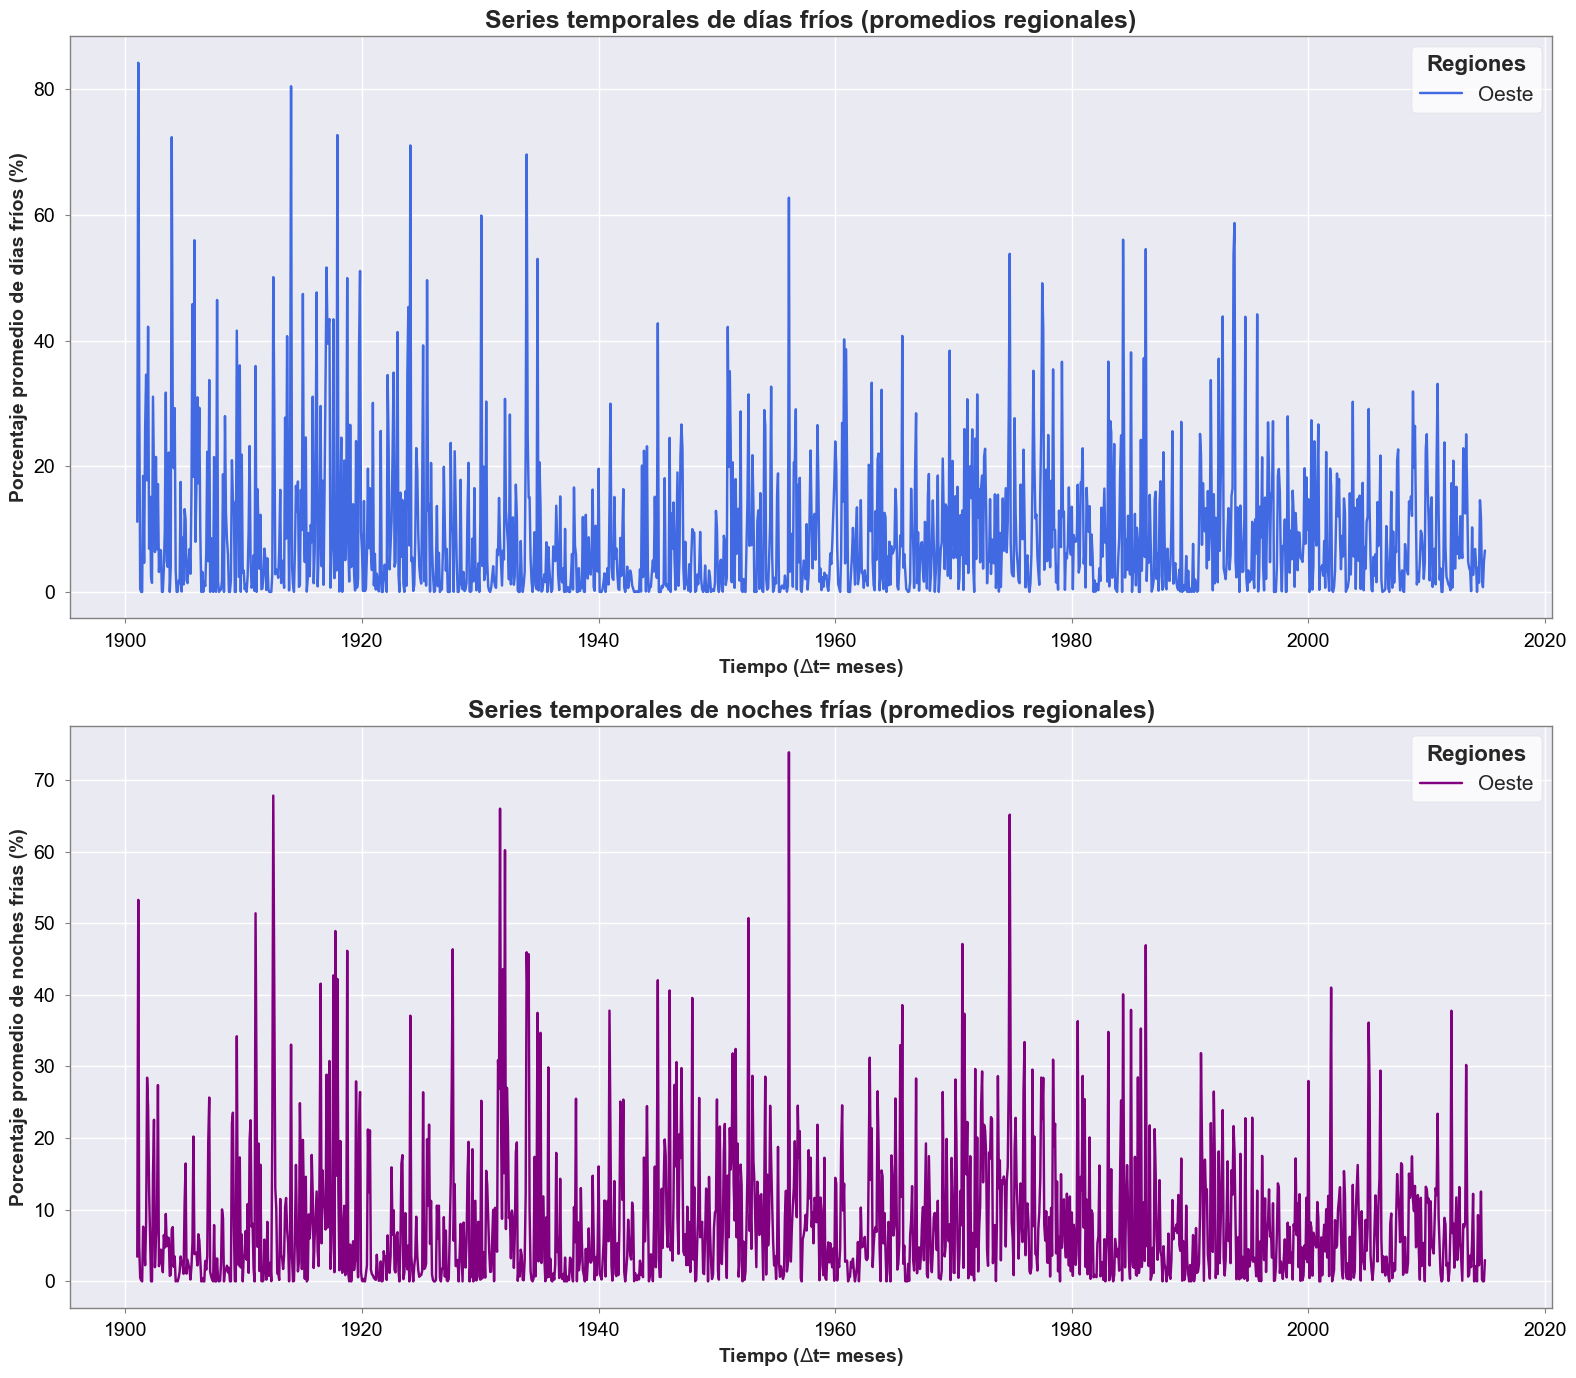

In [131]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_O_monthly
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= meses)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_monthly
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= meses)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

Voy a calcular anomalías mensuales:

In [92]:
anom_O = (corr_O_monthly.groupby('time.month')-corr_O_monthly.groupby('time.month').mean('time'))#/(corr_O_monthly.groupby('time.month').std('time'))

In [93]:
anom_O_std = anom_O.groupby('time.month')/corr_O_monthly.groupby('time.month').std('time')
anom_O_std

<xarray.DataArray (time: 1368)>
array([-0.11401401,  4.79974387,  2.51817406, ..., -0.63320051,
       -0.43841266, -0.34293353])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [94]:
anom_ON_std = (corrN_O_monthly.groupby('time.month')-corrN_O_monthly.groupby('time.month').mean('time')).groupby('time.month')/corrN_O_monthly.groupby('time.month').std('time')
anom_ON_std

<xarray.DataArray (time: 1368)>
array([-0.63690475,  3.09378631, -0.13021036, ..., -0.86298774,
       -0.90487515, -0.51253439])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-01 1901-02-01 ... 2014-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

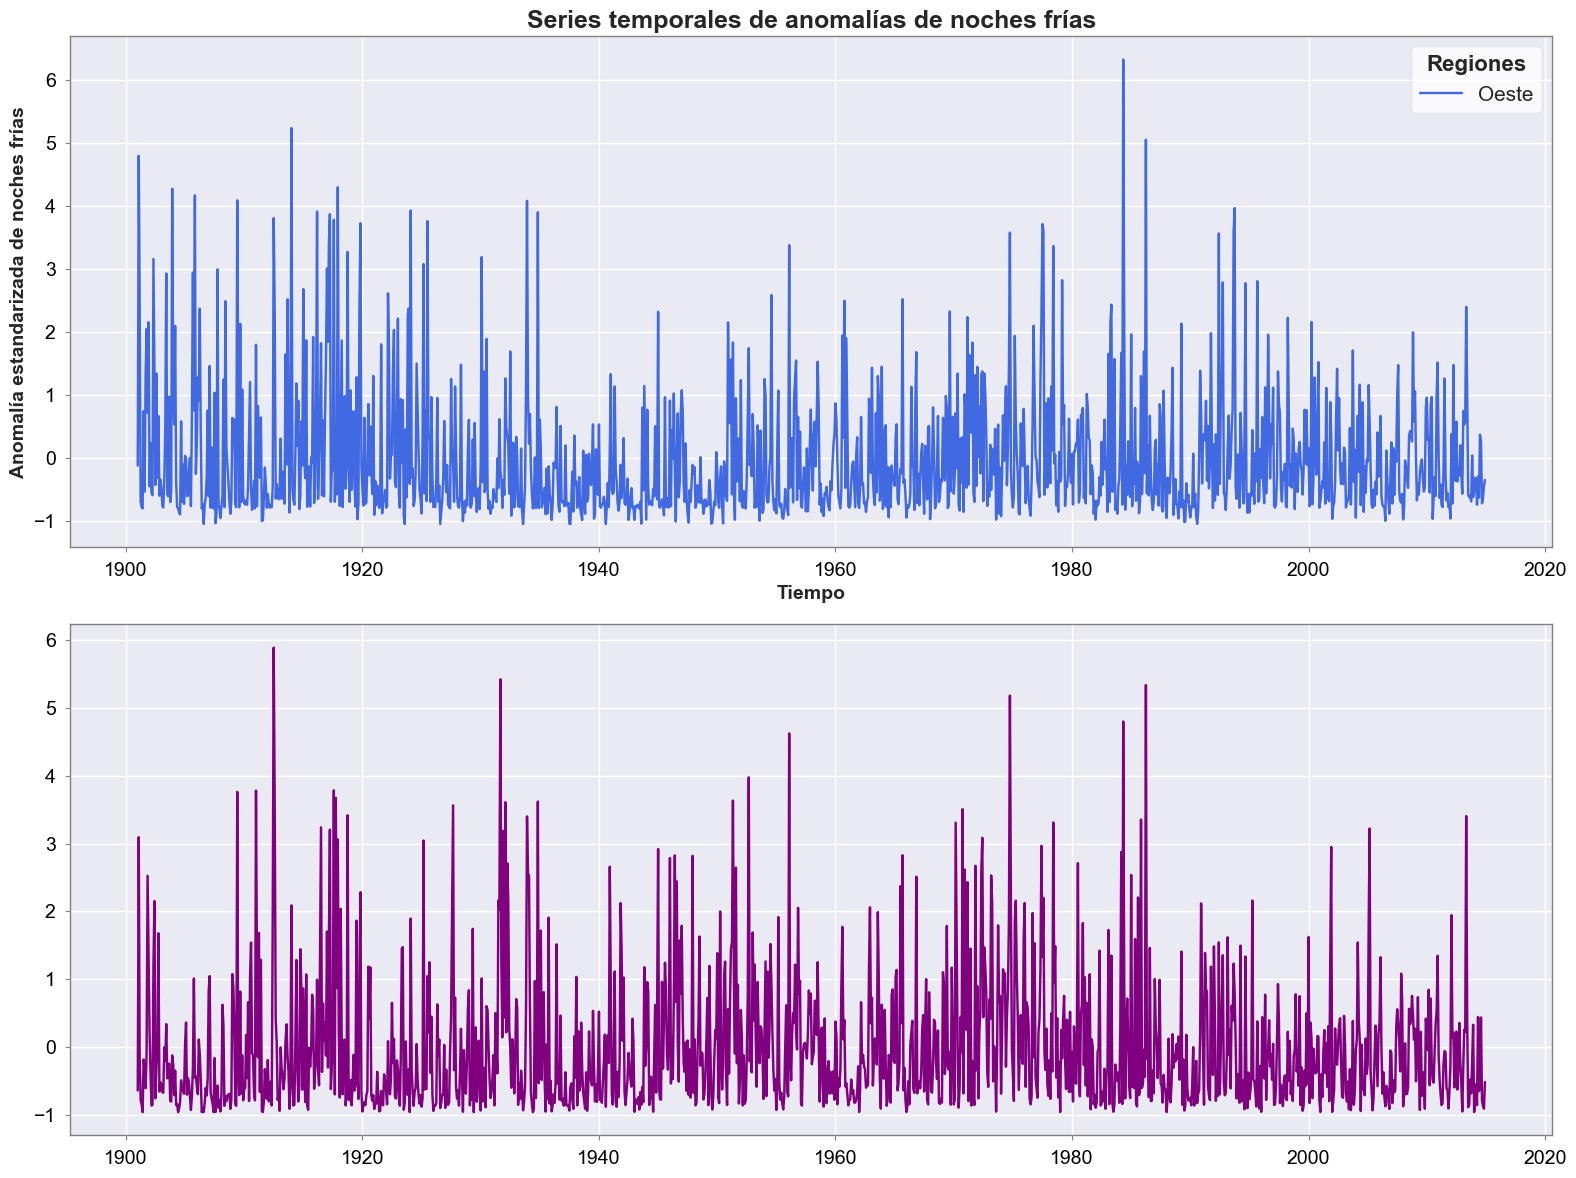

In [95]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,12))
años = anom_O_std.time
ax.plot(años,anom_O_std ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Tiempo')
ax.set_ylabel(u'Anomalía estandarizada de días fríos')
ax.set_title('Series temporales de anomalías de días fríos')

var = anom_ON_std
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax.set_xlabel(u'Tiempo')
ax.set_ylabel(u'Anomalía estandarizada de noches frías')
ax.set_title('Series temporales de anomalías de noches frías')
plt.tight_layout()

---

## Periodograma (de la serie de anomalías mensuales)

In [96]:
# Funciones definidas en la libreta de clase
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

La varianza de la serie original, es  <xarray.DataArray ()>
array(1.)
La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es  1.0000000000000067 0.9999999999999998


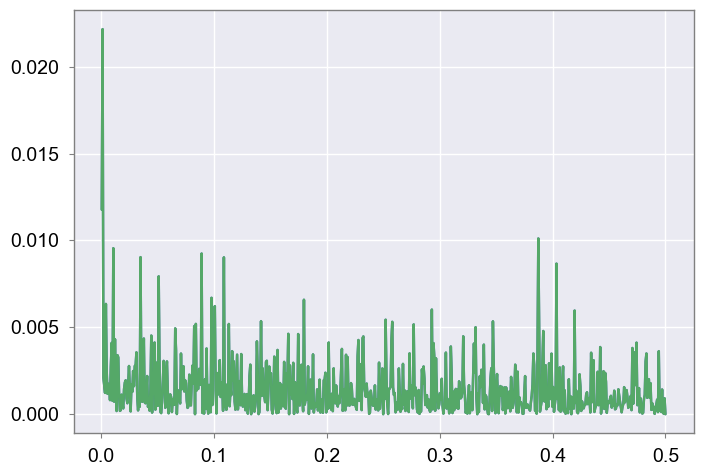

In [97]:
# Vamos a dibujar el espectro de la serie temporal
x = anom_O_std
fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
plt.plot(fa,Ga)
plt.plot(ff,Gf)
print('La varianza de la serie original, es ',np.var(x))
print('La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es ',np.sum(Ga),np.sum(Gf))

La varianza de la serie es  0.9999999999999972
La integral del espectro es  0.9999999999999999
La varianza de la serie es  1.0000000000000002
La integral del espectro es  0.9999999999999998


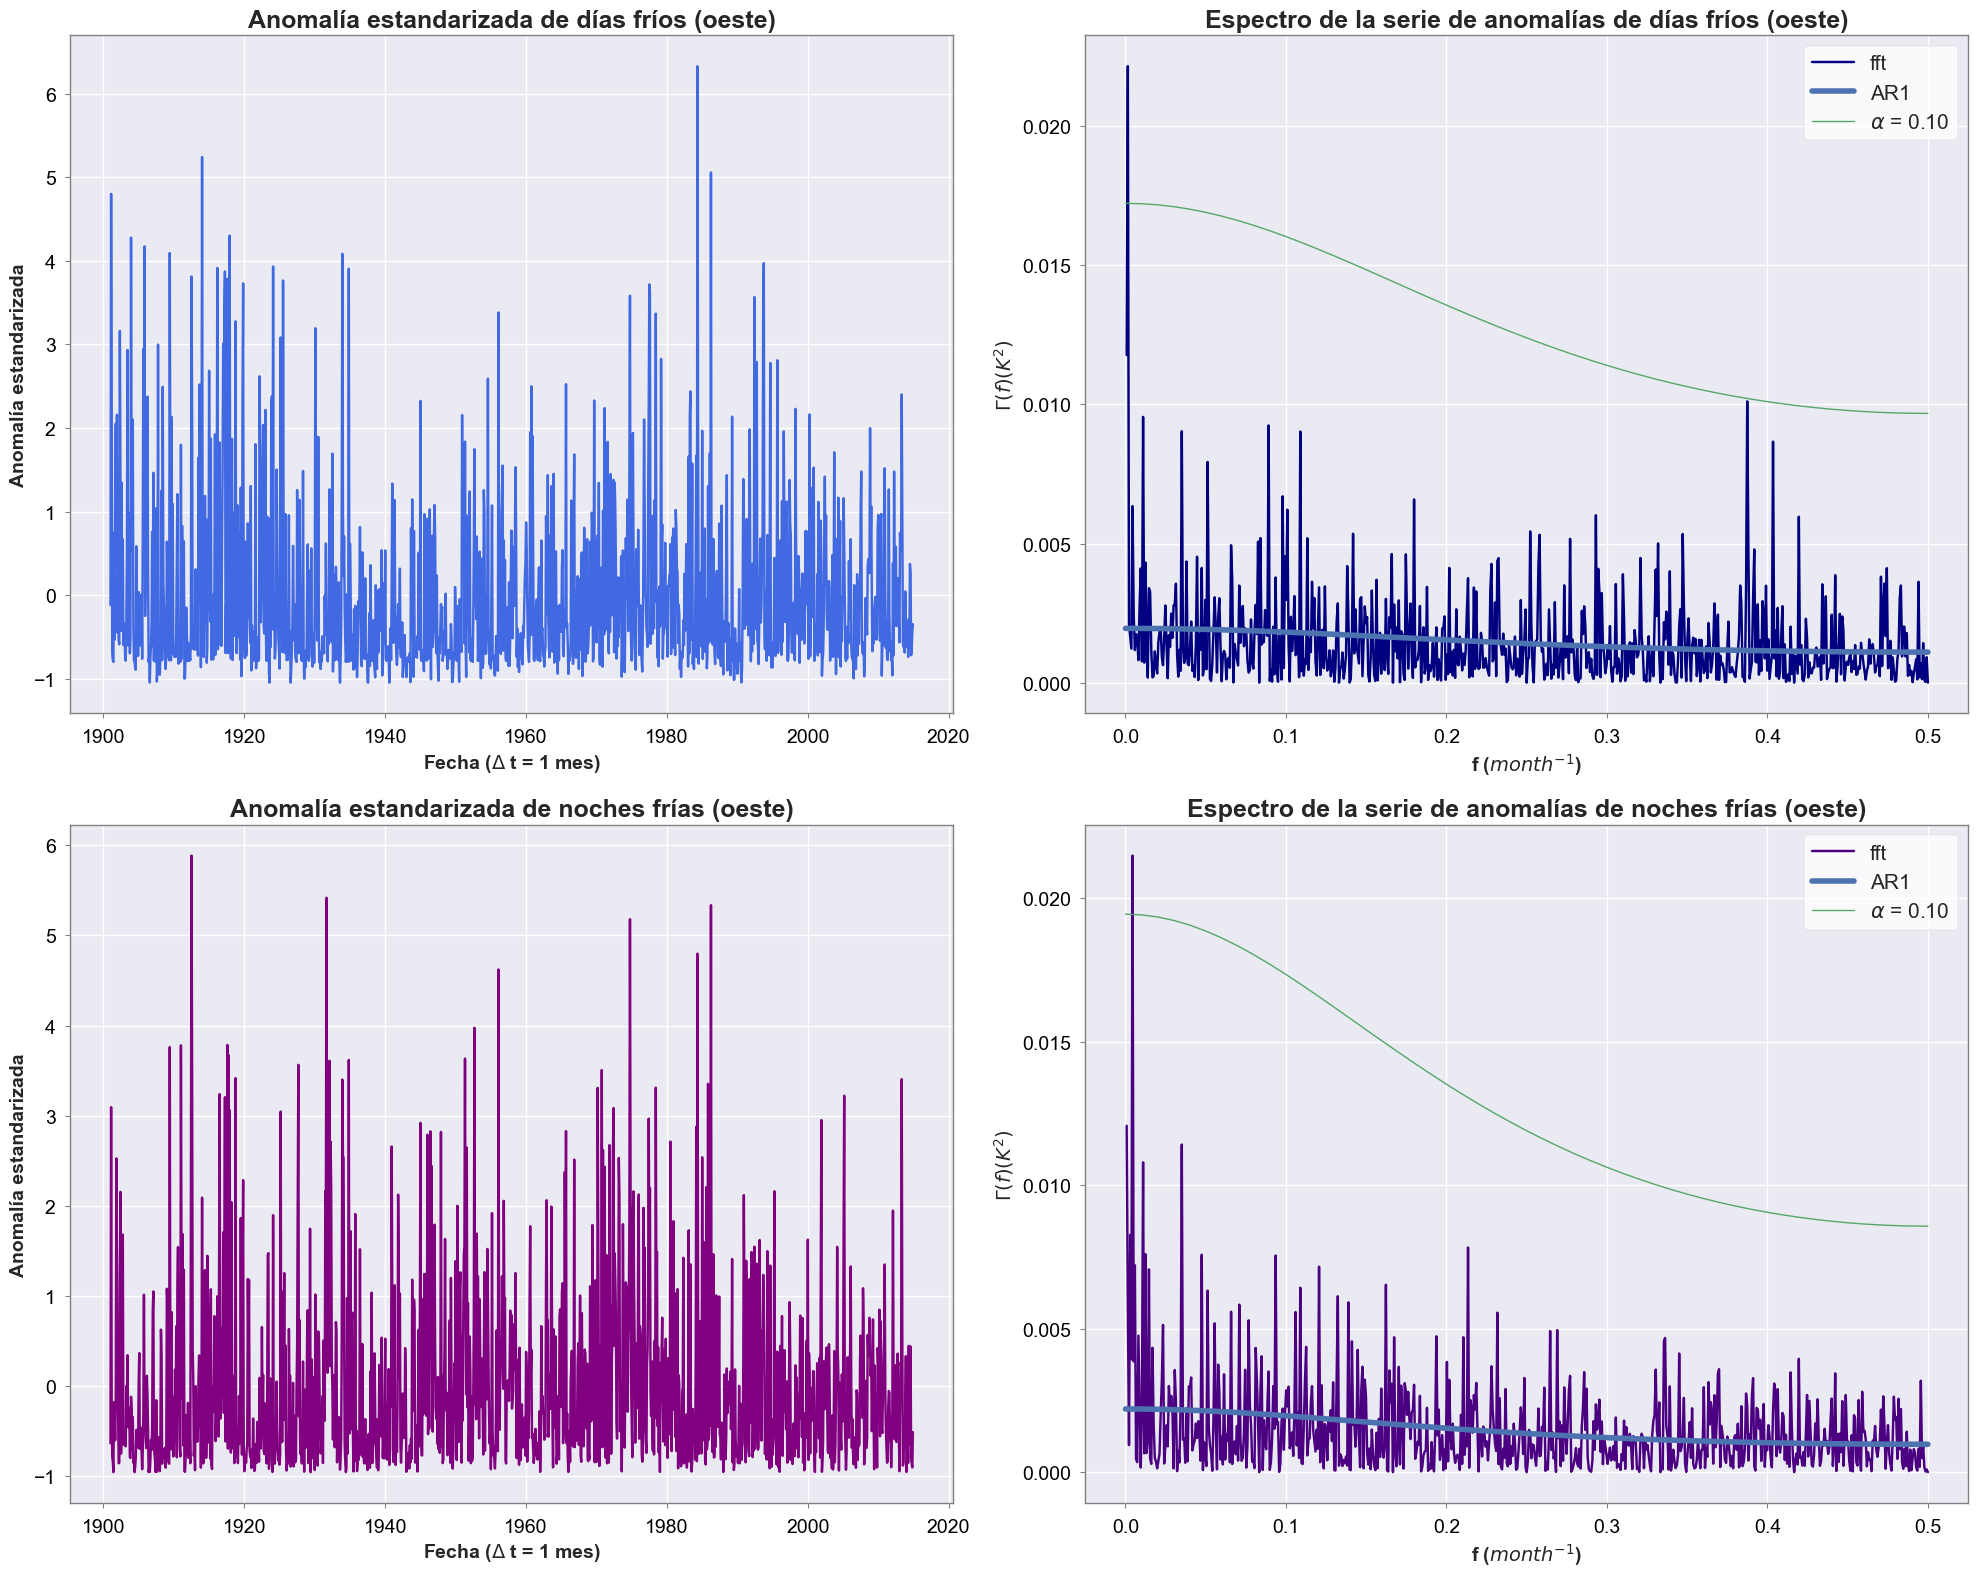

In [98]:
fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))

x = anom_O_std
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x = anom_ON_std
axd[0].plot(años,x,color='purple')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
axd[1].plot(ff,Gf,label='fft',color='indigo')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()


#ax[1].set_xlim(0,0.02)
#axd[1].set_xlim(0,0.02)



plt.tight_layout()

---

Voy a intentar hacerlo por estaciones:

In [109]:
# Algunas funciones de https://docs.xarray.dev/en/v0.9.2/examples/monthly-means.html
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [127]:
def resample_month_to_season(ds):
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100
    return result
corrN_O_seasons = resample_month_to_season(corrN_O_monthly)
corr_O_seasons = resample_month_to_season(corr_O_monthly)

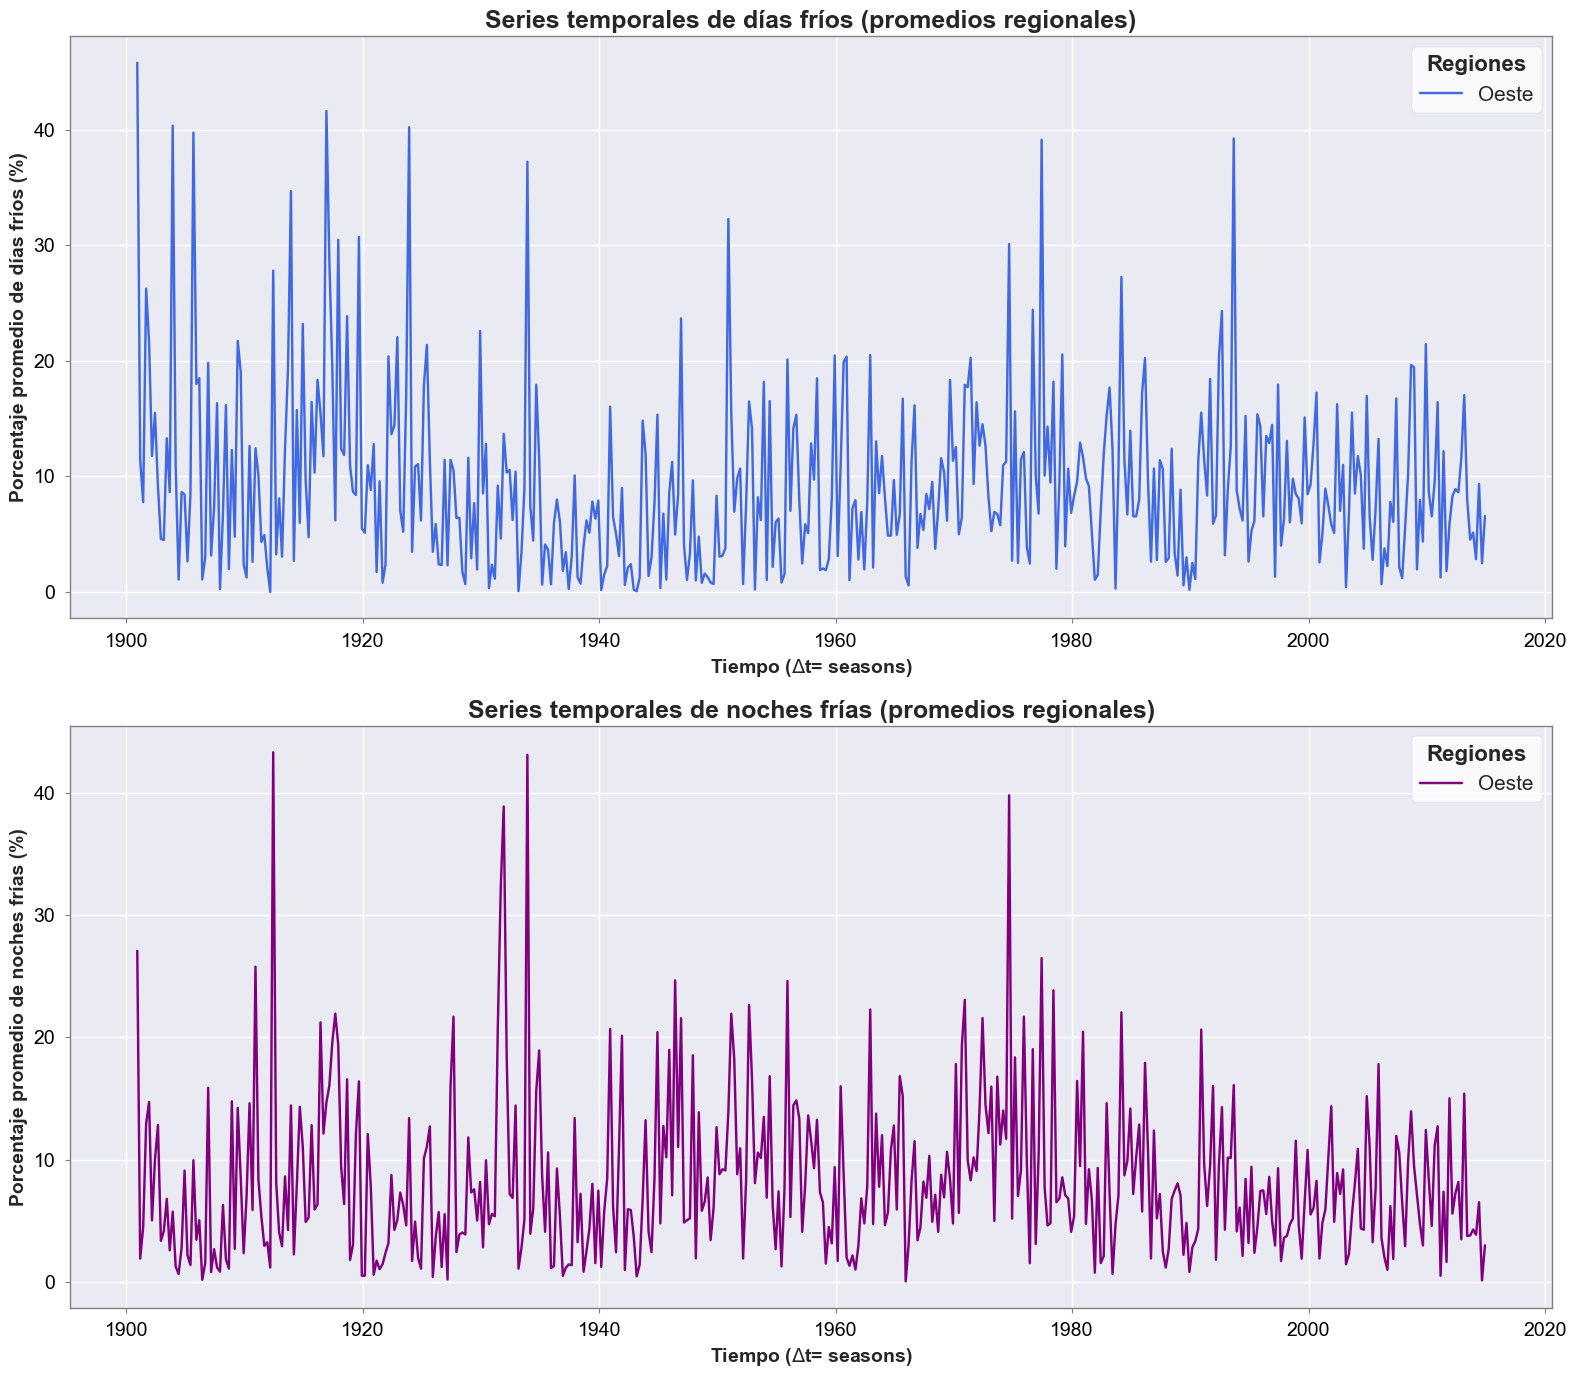

In [130]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

var = corr_O_seasons
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_seasons
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Tiempo ($\Delta$t= seasons)')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

Ahora voy a intentar seleccionar una cierta estación de cada año:

In [154]:
# Seleccionaré las primaveras, representadas por su primer mes: marzo
corrN_O_spring = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==3))
corr_O_spring = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==3))

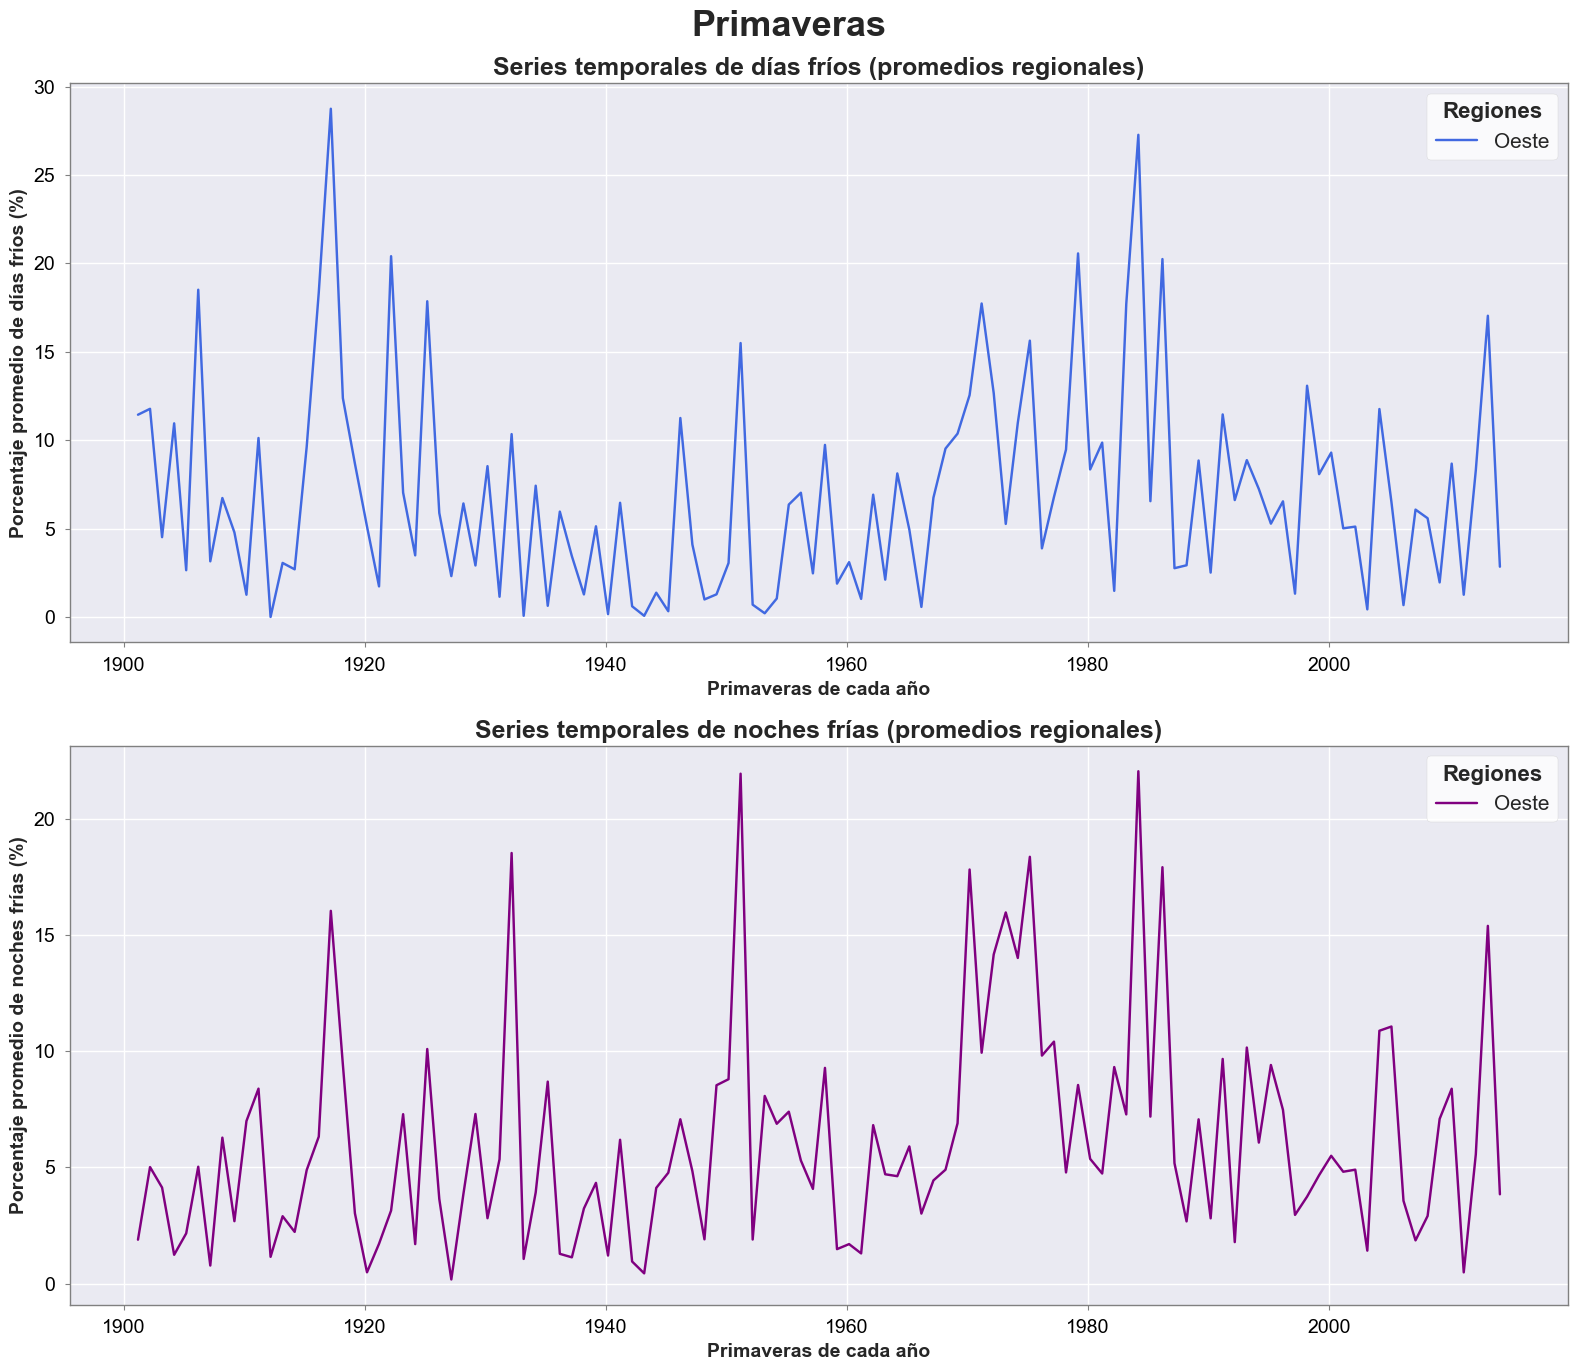

In [155]:
series_style()
fig, (ax,ax2) = plt.subplots(2,1,figsize = (16,14))

fig.suptitle('Primaveras',size=26,weight='bold')
var = corr_O_spring
ax.plot(var.time,var ,color='royalblue',label='Oeste')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(r'Primaveras de cada año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')

var = corrN_O_spring
ax2.plot(var.time,var ,color='purple',label='Oeste')
ax2.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax2.set_xlabel(r'Primaveras de cada año')
ax2.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax2.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

In [160]:
def armonics_plot(days,nights,season):

    fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))


    # Fila de arriba
    var = days
    x = (var-var.mean())/var.std() # Calculo la anomalía
    ax[0].plot(x.time,x,color='royalblue')
    ax[0].set_ylabel(u'Anomalía estandarizada')
    ax[0].set_xlabel(r'%s de cada año'%(season))
    ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    ax[1].plot(ff,Gf,label='fft',color='navy')
    ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    ax[1].set_xlabel(r'f ($año^{-1}$)')
    ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    ax[1].legend()



    # Fila de abajo
    var = nights
    x = (var-var.mean())/var.std() # Calculo la anomalía
    axd[0].plot(x.time,x,color='purple')
    axd[0].set_ylabel(u'Anomalía estandarizada')
    axd[0].set_xlabel(r'%s de cada año'%(season))
    axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


    #fa,Ga = espectroArmonico(x,1)
    ff,Gf = espectroFFT(x,1)
    #ax[1].plot(fa,Ga,linewidth=1)
    axd[1].plot(ff,Gf,label='fft',color='indigo')
    axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
    axd[1].set_xlabel(r'f ($año^{-1}$)')
    axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

    print('La varianza de la serie es ',float(np.var(x)))
    print('La integral del espectro es ',sum(Gf))


    #Veamos si los picos sobresalen lo suficiente:
    alpha = 0.1
    alphaS = alpha / Gf.size
    nu = 2
    chi2 = stats.chi2.ppf(1-alphaS,2)
    N = x.size
    s2 = float(np.var(x))
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    # a = 0 #Para ruido blanco
    f,G = redSpectra(a,s2)
    axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
    Gmax = G/x.size/nu*chi2
    axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
    a,s2,chi2
    axd[1].legend()

    fig.suptitle(r'%s'%(season),size=26,weight='bold')

    #ax[1].set_xlim(0,0.02)
    #axd[1].set_xlim(0,0.02)



    plt.tight_layout()
    return fig, (ax,axd)

La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.00389507889661
La varianza de la serie es  1.0
La integral del espectro es  1.0012143615931435


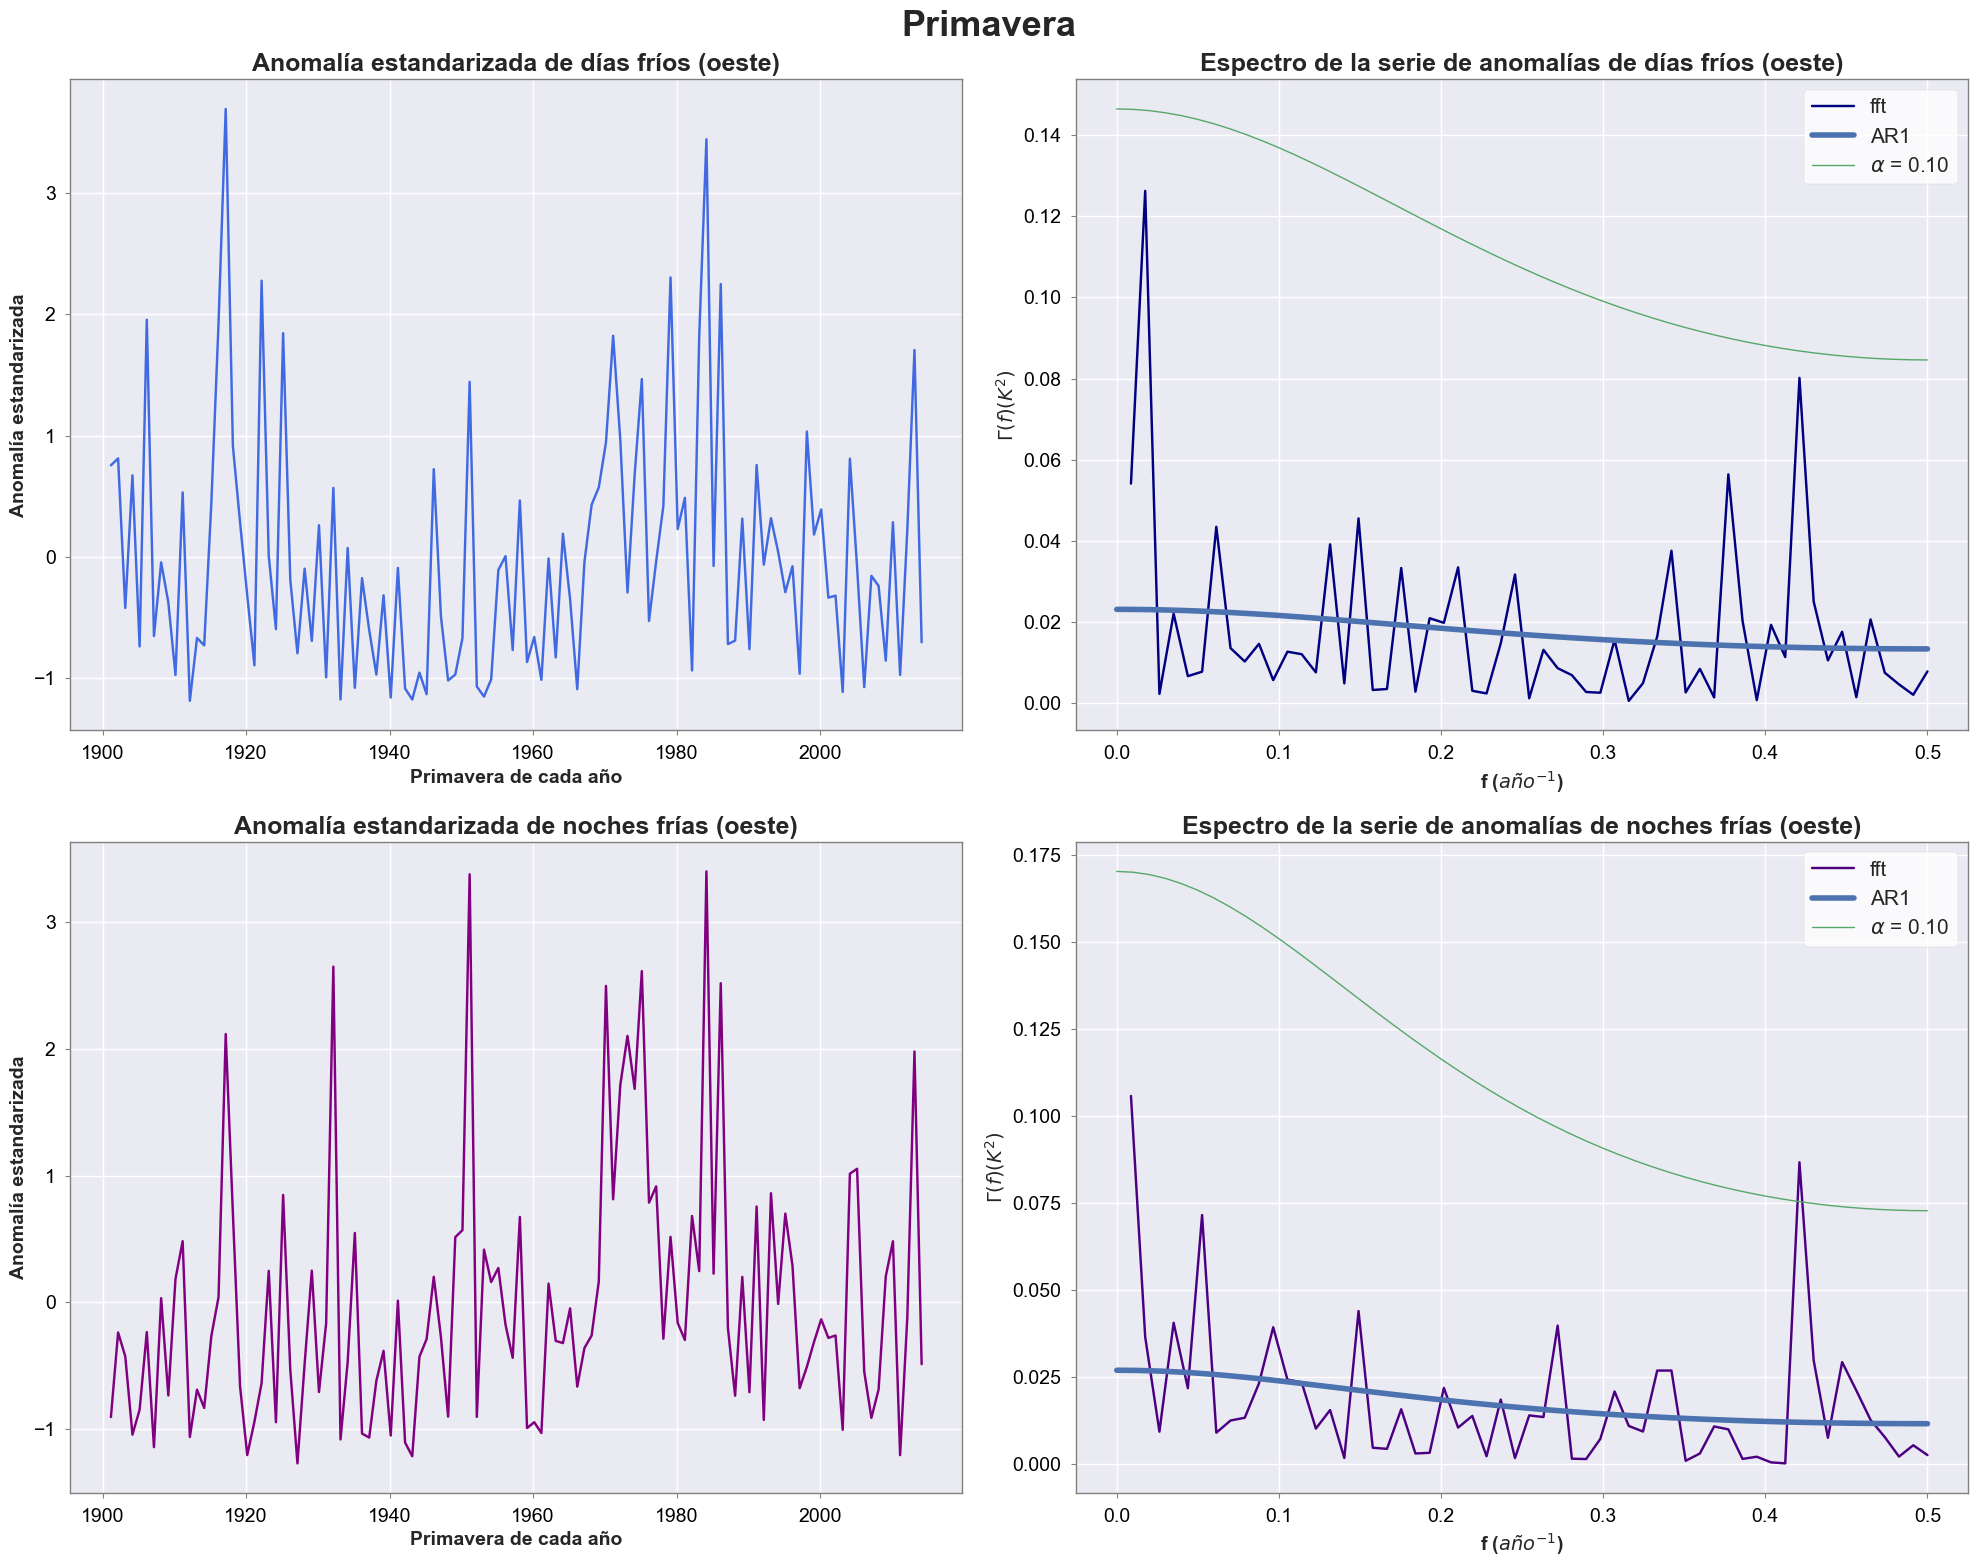

In [162]:
fig, (ax,axd) = armonics_plot(corr_O_spring,corrN_O_spring,'Primavera')

Ahora para más estaciones:

In [164]:
# Seleccionaré los demás, representadas por su primer mes: marzo
corrN_O_summer = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==6))
corr_O_summer = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==6))

corrN_O_fall = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==9))
corr_O_fall = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==9))

corrN_O_winter = corrN_O_seasons.sel(time=(corrN_O_seasons.time.dt.month==12))
corrN_O_winter = corrN_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos
corr_O_winter = corr_O_seasons.sel(time=(corr_O_seasons.time.dt.month==12))
corrN_O_winter = corr_O_winter.sel(time=slice('1901','2014')) # Hay que quitar el primero y último, no están completos

La varianza de la serie es  1.0000000000000002
La integral del espectro es  1.0025232343779324
La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0149428699331264


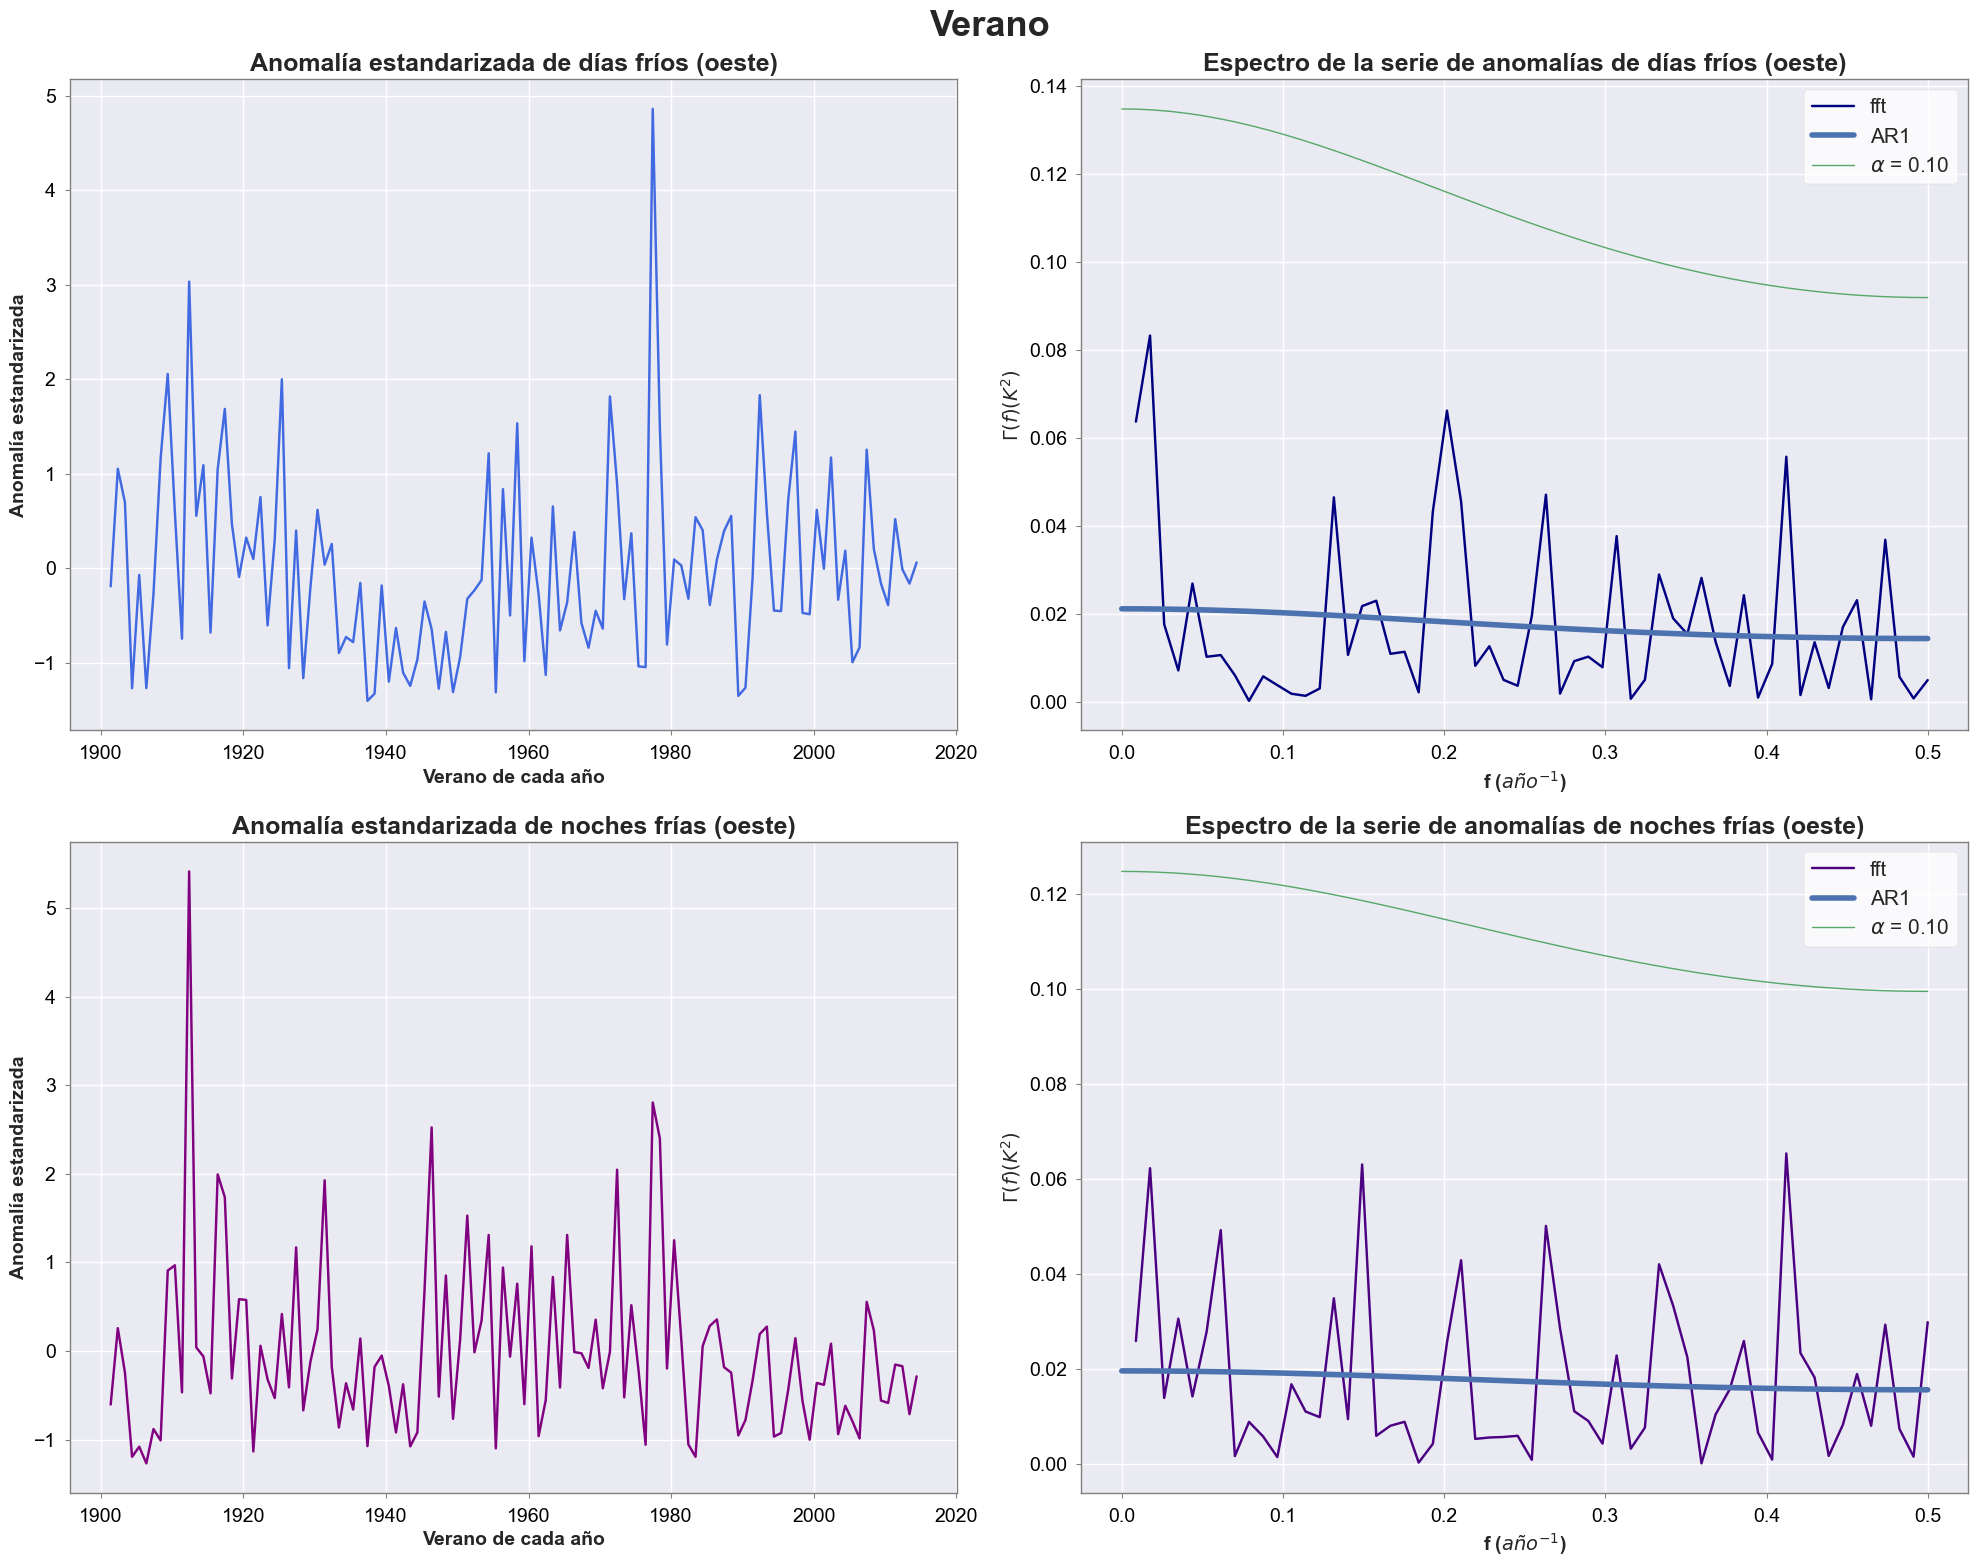

In [165]:
fig, (ax,axd) = armonics_plot(corr_O_summer,corrN_O_summer,'Verano')

La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0051272077073836
La varianza de la serie es  1.0
La integral del espectro es  1.0008989870117735


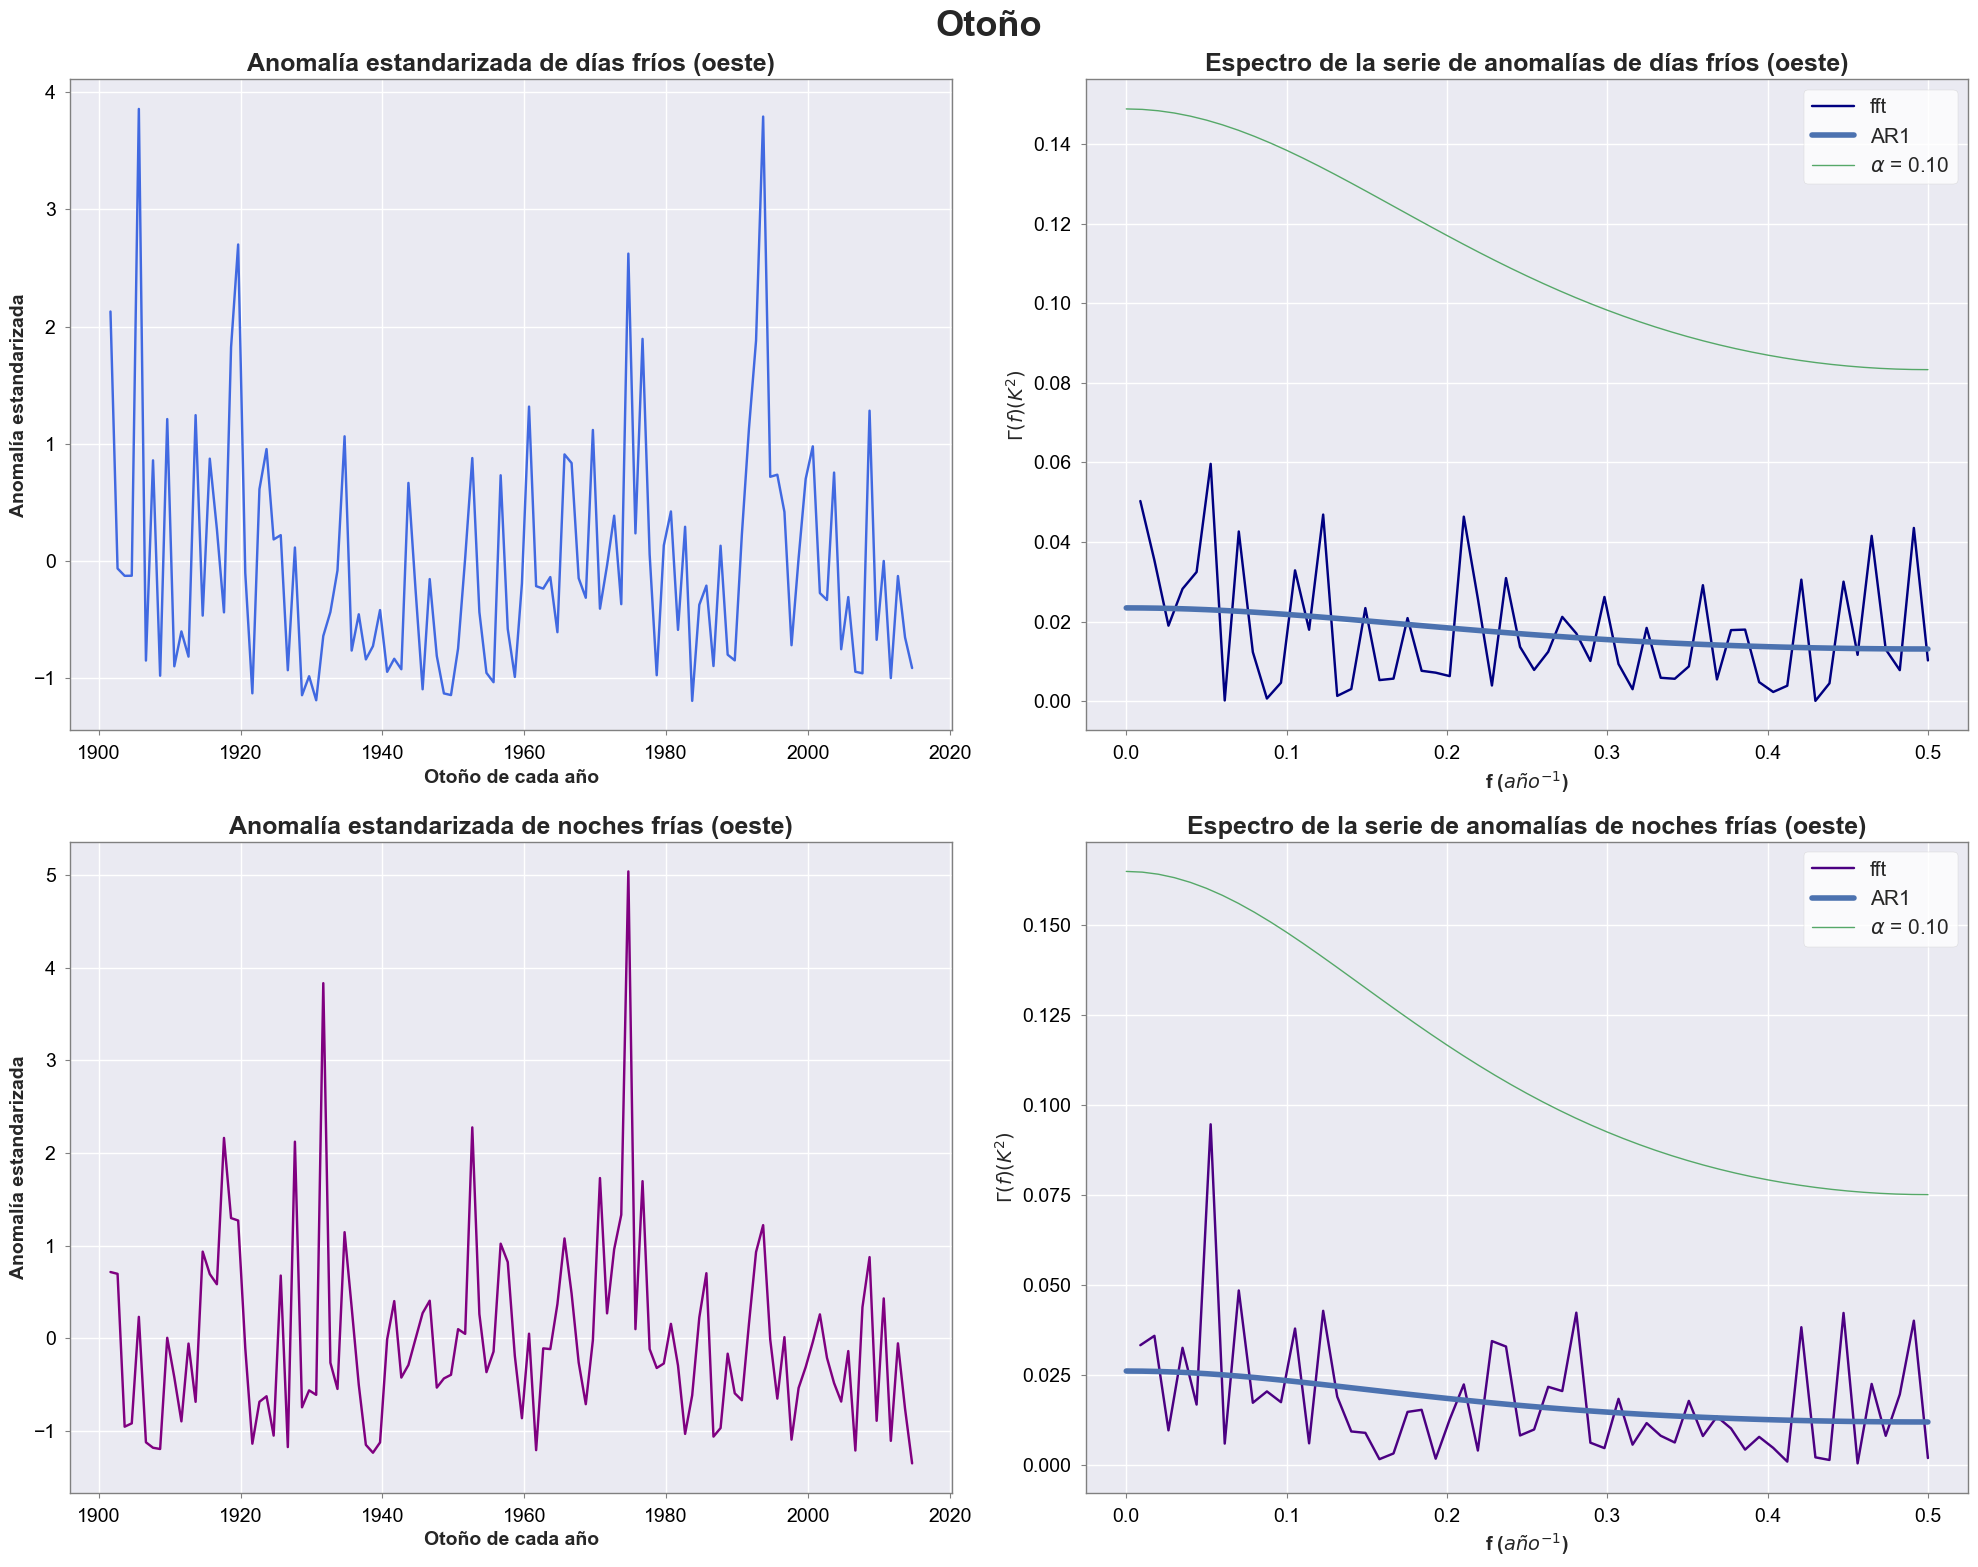

In [166]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Otoño')

La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0051272077073836
La varianza de la serie es  1.0
La integral del espectro es  1.0008989870117735


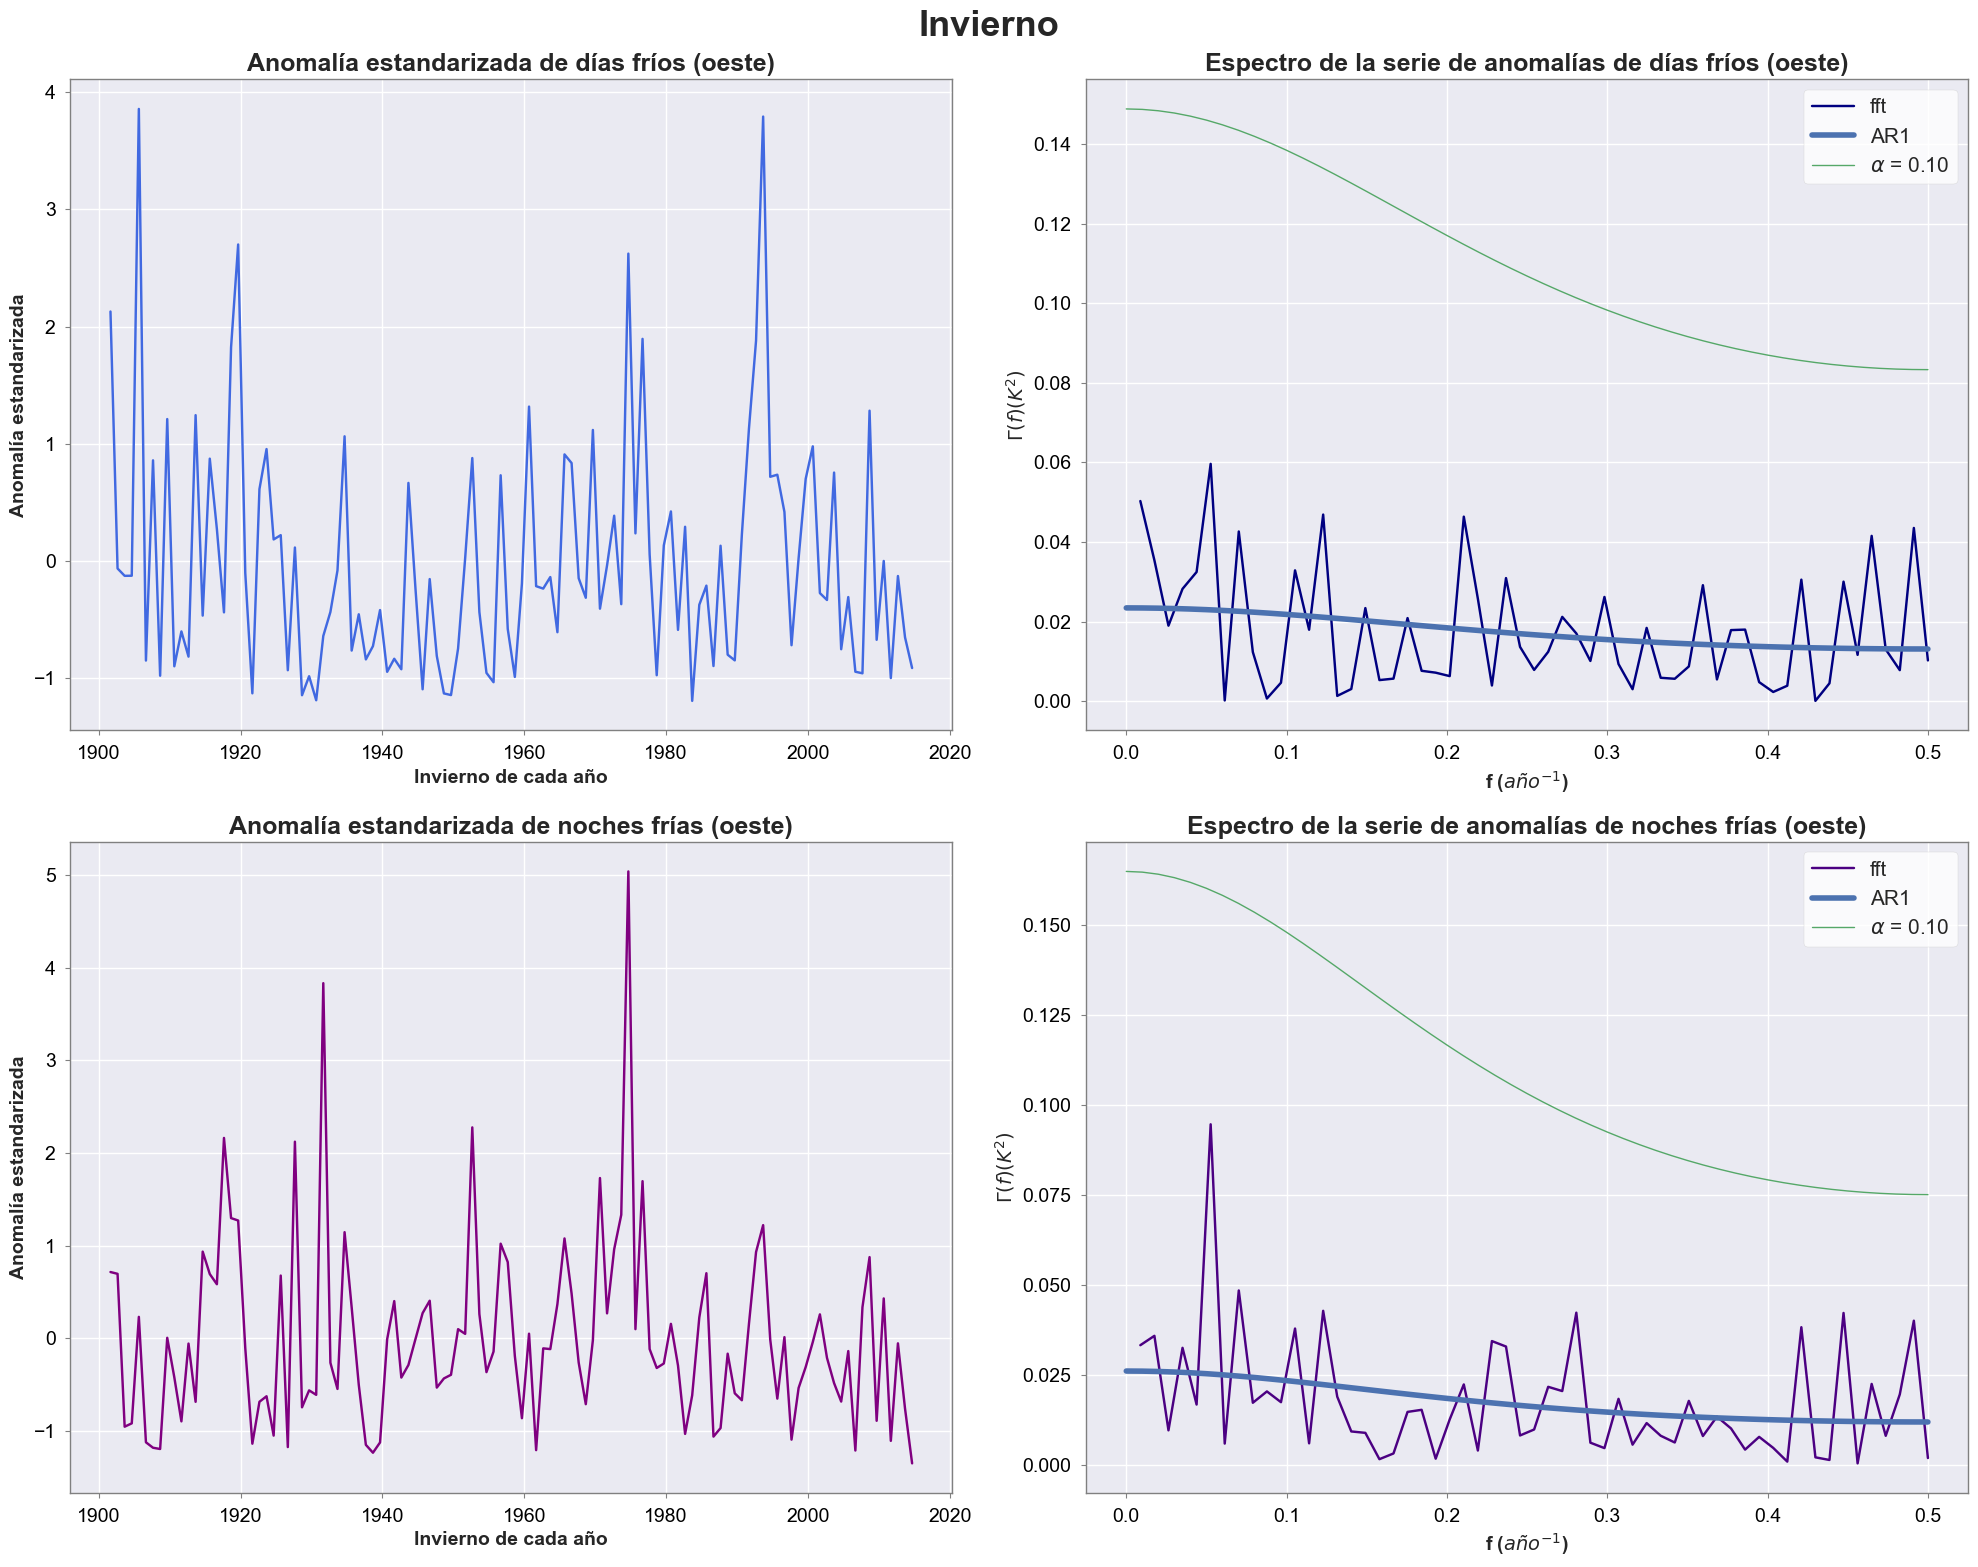

In [167]:
fig, (ax,axd) = armonics_plot(corr_O_fall,corrN_O_fall,'Invierno')

---

## Ajuste GEV y GPD (de los datos de temperatura)

#Ajuste usando herramienta de scipy:
x = tminO
c, m, s = stats.genextreme.fit(x)
c = - c
print('MLE ='+'%.3f'%(MLE_GEV(c,m,s,x)))
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('100yr return value = '+'%.3f'%(returnLevel(0.01,c,m,s)))
diagnosticsGEV(x,c,m,s)